# Imports

In [31]:
import pandas as pd
import re
import warnings
import torch
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Functions for data processing and EDA

In [32]:
def fix_timestamp_format(timestamp):
    # Remove "AM" or "PM" from 24-hour time (13:00 and later)
    match = re.search(r'(\d{2}):(\d{2}):(\d{2})\s([AP]M)\sUTC', timestamp)
    if match:
        hour = int(match.group(1))

        if hour >= 13:
            timestamp = re.sub(r'\s[AP]M\sUTC', ' UTC', timestamp)
    try:
        # try with 12-hour format
        return pd.to_datetime(timestamp, format='%b-%d-%Y %I:%M:%S %p UTC', errors='raise')
    except ValueError:
        # try with 24-hour format
        return pd.to_datetime(timestamp, format='%b-%d-%Y %H:%M:%S UTC', errors='coerce')

In [33]:
# Function for displaying basic information about the dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def basic_data_preprocessing(dataframe):
    # Convert all column titles to lowercase with "_" between words
    dataframe.columns = [x.lower().replace(' ', '_') for x in dataframe.columns.values]

    # Basic information about the dataset
    rows_num, columns_num = dataframe.shape
    print(f'Number of records: {rows_num}')
    print(f'Number of columns: {columns_num}\n')
    print('-' * 75)

    # Dataset information
    print("\nDataset Information:")
    dataframe.info()
    print()
    print('-' * 75)

    # Checking for missing values
    missing_values = dataframe.isnull().sum()
    if missing_values.sum() > 0:
        print("Missing values:")
        display(pd.DataFrame(missing_values, columns=['Missing Count']))
        display(dataframe[dataframe.isna().any(axis=1)])
    else:
        print("No missing values.")
    print('-' * 75)

    # Checking for zero-filled columns
    zero_columns = dataframe.columns[(dataframe == 0.0).any()]
    zero_count = dataframe[zero_columns].apply(lambda x: x.value_counts().get(0, 0))
    if zero_count.sum() != 0:
        print('Rows with value 0 found:')
        display(pd.DataFrame(zero_count, columns=['Zero Count']))
    else:
        print('No rows with value 0.')
    print('-' * 75)

    # Checking for duplicates
    if dataframe.duplicated().sum() > 0:
        print("Duplicate data found. Number of duplicates:", dataframe.duplicated().sum())
        display(dataframe[dataframe.duplicated(keep=False)])
    else:
        print("No duplicates found.")
    print('-' * 75)

    # Checking for negative values in the dataframe
    # Excluding columns with string data type (object type)
    dataframe_digits = dataframe.select_dtypes(exclude=['object', 'datetime'])
    if (dataframe_digits < 0).sum().sum() > 0:
        print("Negative values found:")
        display(pd.DataFrame((dataframe_digits < 0).sum(), columns=['Negative Value Count']))
    else:
        print('No negative values found.')
    print('-' * 75)

    # Statistical description of the data
    print("\nStatistical Description of the Data:\n")
    display(dataframe.describe())
    print('-' * 75)

In [34]:
# Function for detecting outliers in a dataframe
# Displays boxplots and a table with outlier information

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def detect_outliers(dataframe):
    outlier_table = pd.DataFrame(columns=['Column', 'Outlier Count', 'Outlier Percentage'])  # Creating a DataFrame to store outlier information

    for column in dataframe.columns:
        if dataframe[column].dtype != 'object' and len(dataframe[column].unique()) == 2:  # Checking for columns with binary values
            print(f"No outliers in column '{column}' as it has binary values.")  # Printing a message indicating binary values
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': ['NaN'],
                                       'Outlier Percentage': ['NaN']})],
                                       ignore_index=True)  # Updating the outlier table with binary value information
            print('*' * 75)
            print()
            continue  # Skipping to the next iteration if the column has binary values

        # skipping the object type
        if dataframe[column].dtype == 'object':
            break

        q1 = dataframe[column].quantile(0.25)  # Calculating the first quartile
        q3 = dataframe[column].quantile(0.75)  # Calculating the third quartile
        iqr = q3 - q1  # Calculating the interquartile range
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Counting the number of outliers
        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        num_outliers = len(outliers)
        column_len = len(dataframe[column])

        if num_outliers == 0:
            print(f"No outliers in column '{column}'.")
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                                    'Outlier Count': [0],
                                                    'Outlier Percentage': [0]})],
                                                    ignore_index=True)  # Updating the outlier table with outlier count
        else:
            print(f"Outliers in column '{column}':")
            print(f"Outlier Count: {num_outliers}")
            print(f"Outlier Percentage of total observations: {(num_outliers / column_len) * 100:.2f}%")  # Calculating and displaying outlier percentage
            print("Outlier Values:", ", ".join(outliers[column].astype(str)))

            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': [num_outliers],
                                       'Outlier Percentage': [(num_outliers / column_len) * 100]})],
                                       ignore_index=True)  # Updating the outlier table with outlier information

            # Plotting the boxplot with outliers
            fig, ax = plt.subplots(figsize=(8, 6))
            sns.boxplot(data=dataframe, x=column, ax=ax)
            ax.set_title(f"Outlier Plot for column '{column}'")
            plt.show()

        print('*' * 75)
        print()

    display(outlier_table)

In [35]:
# Correlation analysis on a dataframe with a target feature using some specified correlation types

!pip install phik
from phik import phik_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def correlation_analysis(dataframe, target_feature, correlation_types=['phik'], apply_abs=False):
    target_column = dataframe[target_feature] # Target feature
    correlation_data = [] # List to store correlations
    interval_cols = [col for col in dataframe.columns if col != target_feature] # Set interval columns for phik

    # Calculate correlation coefficients with the target feature for each column and specified correlation types
    for column in dataframe.columns:
        if column != target_feature:
            for corr_type in correlation_types:
                corr_value = None

                if corr_type == 'pearson':
                    corr_value = stats.pearsonr(target_column, dataframe[column])[0]
                elif corr_type == 'spearman':
                    corr_value = stats.spearmanr(target_column, dataframe[column]).correlation
                elif corr_type == 'kendall':
                    corr_value = stats.kendalltau(target_column, dataframe[column]).correlation
                elif corr_type == 'phik':
                    corr_value = phik_matrix(dataframe, interval_cols=interval_cols)[target_feature][column]
                # Apply absolute value, if specified
                if corr_value is not None and apply_abs:
                  corr_value = abs(corr_value)
                correlation_data.append((column, corr_type, corr_value))

    correlation_df = pd.DataFrame(correlation_data, columns=['Column', 'Correlation Type', 'Correlation Value'])  # Create DataFrame
    correlation_df_sorted = correlation_df.pivot(index='Column', columns='Correlation Type', values='Correlation Value')
    correlation_df_sorted = correlation_df_sorted[correlation_types] # Keep only specified correlation types
    correlation_df_sorted = correlation_df_sorted.sort_values(by=correlation_types, ascending=False) # Sort the data by specified correlation types


    # Correlation plot
    fig, axes = plt.subplots(nrows=1, ncols=len(correlation_types), figsize=(8 * len(correlation_types), 6))

    for i, corr_type in enumerate(correlation_types):
        corr_with_target = correlation_df_sorted[corr_type]
        corr_with_target_sorted = corr_with_target.sort_values(ascending=True) # Sort the data

        # Set plot parameters
        sns.barplot(data=corr_with_target_sorted.reset_index(), x='Column', y=corr_type, ax=axes[i], color='dodgerblue')


        axes[i].set_xlabel('Features')
        axes[i].set_ylabel('Correlation')
        axes[i].set_title(corr_type)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)
    plt.tight_layout(pad=1)
    plt.show()


    # Top 2 features with the highest correlation for each specified correlation type
    top_columns = {}
    for corr_type in correlation_types:
        sorted_columns = correlation_df_sorted[corr_type].abs().sort_values(ascending=False)
        top_columns[corr_type] = sorted_columns.index[:2].tolist()

    # Display correlation table
    print(f"Correlation table with target feature '{target_feature}':")
    display(correlation_df_sorted)

    # Display the top 2 features with the highest correlation for each correlation type
    for corr_type in correlation_types:
        print()
        print(f"Top 2 features with highest correlation ({corr_type.capitalize()}):", top_columns[corr_type])

In [36]:
# Function to find multicollinearity and print correlation matrix
# !pip install phik
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from phik import phik_matrix

def find_multicollinearity(dataframe, methods=['phik'], threshold=0.8):
    # List to store all multicollinear tables
    multicollinear_tables = []

    # Iterate through each method in the list of methods
    for method in methods:
        # Convert method to lowercase
        method = method.lower()

        # Calculate correlation matrix using specified sort method
        if method in ['pearson', 'kendall', 'spearman']:
            corr_matrix = dataframe.corr(method=method).abs()
        elif method == 'phik':
            interval_cols = [col for col in dataframe.columns]
            corr_matrix = phik_matrix(dataframe, interval_cols=interval_cols)
        else:
            print(f"Invalid method: {method}")
            continue

        # Exclude correlation of a variable with itself
        np.fill_diagonal(corr_matrix.values, np.NaN)

        # Create a larger figure size based on the number of features
        n = corr_matrix.shape[0]
        fig_width = 6 + n * 0.5
        fig_height = 4 + n * 0.3

        # Plot correlation matrix as heatmap with adjusted figure size
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", mask=np.isnan(corr_matrix))
        plt.title(f"Correlation Matrix ({method})")
        plt.show()

        # Initialize an empty list to store multicollinear features
        multicollinear_table = []

        # Iterate through each pair of multicollinear features and their correlation percentages
        for i in range(n):
            for j in range(i+1, n):
                # Check if the correlation between the two features is above the threshold
                if corr_matrix.iloc[i, j] > threshold:
                    feature1 = corr_matrix.columns[i]
                    feature2 = corr_matrix.columns[j]
                    # Append the pair of multicollinear features and their correlation percentage to the list
                    multicollinear_table.append({'Feature 1': feature1, 'Feature 2': feature2, 'Correlation': corr_matrix.iloc[i, j]})

        # Create a dataframe from the list of multicollinear features
        multicollinear_table = pd.DataFrame(multicollinear_table)

        if not multicollinear_table.empty:
            # Sort the multicollinear table by correlation in descending order
            multicollinear_table = multicollinear_table.sort_values(by='Correlation', ascending=False)
            # Append the multicollinear table to the list of multicollinear tables
            multicollinear_tables.append((method, multicollinear_table))

    # Print all multicollinear tables
    if multicollinear_tables:
        for method, table in multicollinear_tables:
            print(f"\nMulticollinearity Table ({method})")
            display(table)
    else:
        print("\nNo features with high multicollinearity!")

## Functions for Neural Network training

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [38]:
def train_model_with_validation(model, train_loader, val_loader, optimizer, loss_fn, epochs, device):
    model.to(device)
    model.train()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        # Training
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, X_batch)  # Autoencoder uses reconstruction loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_batch, _ in val_loader:
                X_batch = X_batch.to(device)
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, X_batch)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

In [39]:
from sklearn.model_selection import KFold
import torch
import numpy as np
import pandas as pd

def cross_val_evaluate(model, X, y, optimizer, loss_fn, epochs=10, n_splits=5, device='cpu'):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []
    all_train_losses = []
    all_val_losses = []

    for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
        print(f"Fold {fold+1}/{n_splits}")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Create DataLoader for current fold
        train_loader = torch.utils.data.DataLoader(
            [(torch.tensor(X_train[i], dtype=torch.float32), torch.tensor(y_train.iloc[i], dtype=torch.float32))
             for i in range(len(X_train))],
            batch_size=32, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(
            [(torch.tensor(X_test[i], dtype=torch.float32), torch.tensor(y_test.iloc[i], dtype=torch.float32))
             for i in range(len(X_test))],
            batch_size=32, shuffle=False
        )

        model.to(device)
        optimizer.zero_grad()  # Zeroing optimizer gradients

        # Model training and loss saving
        train_losses, val_losses = train_model_with_validation(
            model, train_loader, test_loader, optimizer, loss_fn, epochs, device
        )

        all_train_losses.extend(train_losses)
        all_val_losses.extend(val_losses)

        # Evaluation on the test with getting confidence
        val_errors = []
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = model(X_batch)

                # Ensure compatible shapes
                if y_batch.dim() == 1:
                    y_batch = y_batch.view(-1, 1)  # Reshape if necessary to [batch_size, 1]

                errors = ((y_batch - y_pred) ** 2).mean(dim=1).cpu().numpy()
                val_errors.extend(errors)

        mean_val_error = np.mean(val_errors)
        std_val_error = np.std(val_errors)

        labels, confidences = calculate_confidence(model, test_loader, loss_fn, mean_val_error, std_val_error)

        fold_results.append(pd.DataFrame({
            'label': labels,
            'confidence': confidences
        }))

    results_df = pd.concat(fold_results, ignore_index=True)
    return results_df, all_train_losses, all_val_losses

In [40]:
def calculate_confidence(model, data_loader, loss_fn, mean_error, std_error):
    model.eval()
    confidences = []
    labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)

            # Calculate errors
            errors = ((X_batch - y_pred) ** 2).mean(dim=1).cpu().numpy()

            if np.any(np.isnan(errors)):
                errors = np.nan_to_num(errors, nan=np.mean(errors))

            std_error = np.std(errors)

            if std_error == 0:
                confidence = np.full_like(errors, 0.5)
            else:
                confidence = 1 - np.clip((errors - mean_error) / (3 * std_error), 0, 1)

            confidences.extend(confidence)
            labels.extend(y_batch.cpu().numpy())

    return np.array(labels), np.array(confidences)


In [41]:
def visualization(train_losses, val_losses):
    plt.figure(figsize=(10, 6))

    plt.plot(train_losses, label="Train Loss", color='red')
    plt.plot(val_losses, label="Validation Loss", color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Data Extraction

In [402]:
import pandas as pd


data = pd.read_csv('test.csv')
df = data.copy()
data

,transaction id,time stamp,from,to,value,method called,token price,liquidity,market cap
0,0xf04403e162a8a988780de9a0416f8b87633e71435f03...,Jul-30-2024 01:53:37 PM UTC,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,$0.12,buy,$2.38,"$1,153,212.96","$3,234,533.45"
1,0x5fb4348e6ef84249f12ec5058e373e956d95913dcdec...,Jul-30-2024 01:53:36 PM UTC,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,$0.02,buy,$2.39,"$1,153,234.56","$3,235,002.04"
2,0x1bf427e14853d650e332b6188962e1ea3b21c02492e2...,Jul-30-2024 12:34:38 AM UTC,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,$2.40,buy,$2.40,"$1,153,266.32","$3,234,113.31"
3,0x737bb2b517312cd2166bacb41daf5c1a80e560d3f0c8...,Jul-30-2024 12:02:23 AM UTC,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,$5,transfer,$2.39,"$1,153,265.16","$3,234,323.80"
4,0x94002f1eabc5b491f9f143bd761ff693362c25e2832f...,Jul-29-2024 21:05:16 AM UTC,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,$3.50,swap,$2.26,"$1,153,344.33","$3,235,421.46"
5,0xe4ecd37edb93d22eef32f62dcb397f23f75b699a0c53...,Jul-29-2024 21:05:15 AM UTC,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,$3.50,swap,$2.26,"$1,153,342.55","$3,235,532.40"
6,0x0232c4dd9f4b88222ed95a25f6236d7dc25b9d3dccb9...,Jul-29-2024 21:05:14 AM UTC,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,$3.50,swap,$2.22,"$1,153,312.90","$3,236,754.55"
7,0xc5061da6f7c89ab0fc20c912f058636a8c3f9d8b0456...,Jul-29-2024 21:05:13 AM UTC,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,$3.50,swap,$2.20,"$1,153,319.12","$3,236,751.09"
8,0x34484bf7d85bc584599957718112f0dc309a45208457...,Jul-30-2024 01:53:38 PM UTC,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,"$2,110",printMoney,$2.21,"$1,153,278.06","$3,235,980.11"


In [403]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction id  9 non-null      object
 1   time stamp      9 non-null      object
 2   from            9 non-null      object
 3   to              9 non-null      object
 4   value           9 non-null      object
 5   method called   9 non-null      object
 6   token price     9 non-null      object
 7   liquidity       9 non-null      object
 8   market cap      9 non-null      object
dtypes: object(9)
memory usage: 776.0+ bytes


# Data Cleanset

In [404]:
for column in ["value", "token price", "liquidity", "market cap"]:
    df[column] = df[column].replace({'\$': '', ',': ''}, regex=True).astype(float)

df

,transaction id,time stamp,from,to,value,method called,token price,liquidity,market cap
0,0xf04403e162a8a988780de9a0416f8b87633e71435f03...,Jul-30-2024 01:53:37 PM UTC,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.12,buy,2.38,1153212.96,3234533.45
1,0x5fb4348e6ef84249f12ec5058e373e956d95913dcdec...,Jul-30-2024 01:53:36 PM UTC,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.02,buy,2.39,1153234.56,3235002.04
2,0x1bf427e14853d650e332b6188962e1ea3b21c02492e2...,Jul-30-2024 12:34:38 AM UTC,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,2.40,buy,2.40,1153266.32,3234113.31
3,0x737bb2b517312cd2166bacb41daf5c1a80e560d3f0c8...,Jul-30-2024 12:02:23 AM UTC,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,5.00,transfer,2.39,1153265.16,3234323.80
4,0x94002f1eabc5b491f9f143bd761ff693362c25e2832f...,Jul-29-2024 21:05:16 AM UTC,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,swap,2.26,1153344.33,3235421.46
5,0xe4ecd37edb93d22eef32f62dcb397f23f75b699a0c53...,Jul-29-2024 21:05:15 AM UTC,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,swap,2.26,1153342.55,3235532.40
6,0x0232c4dd9f4b88222ed95a25f6236d7dc25b9d3dccb9...,Jul-29-2024 21:05:14 AM UTC,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,swap,2.22,1153312.90,3236754.55
7,0xc5061da6f7c89ab0fc20c912f058636a8c3f9d8b0456...,Jul-29-2024 21:05:13 AM UTC,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,swap,2.20,1153319.12,3236751.09
8,0x34484bf7d85bc584599957718112f0dc309a45208457...,Jul-30-2024 01:53:38 PM UTC,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,2110.00,printMoney,2.21,1153278.06,3235980.11


In [405]:
df['time stamp'].sort_values()

,time stamp
7,Jul-29-2024 21:05:13 AM UTC
6,Jul-29-2024 21:05:14 AM UTC
5,Jul-29-2024 21:05:15 AM UTC
4,Jul-29-2024 21:05:16 AM UTC
1,Jul-30-2024 01:53:36 PM UTC
0,Jul-30-2024 01:53:37 PM UTC
8,Jul-30-2024 01:53:38 PM UTC
3,Jul-30-2024 12:02:23 AM UTC
2,Jul-30-2024 12:34:38 AM UTC


In [406]:
# pd.to_datetime(df['time stamp'], format='%b-%d-%Y %I:%M:%S %p UTC')

In [407]:
df['time stamp'] = df['time stamp'].apply(fix_timestamp_format)
df

,transaction id,time stamp,from,to,value,method called,token price,liquidity,market cap
0,0xf04403e162a8a988780de9a0416f8b87633e71435f03...,2024-07-30 13:53:37,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.12,buy,2.38,1153212.96,3234533.45
1,0x5fb4348e6ef84249f12ec5058e373e956d95913dcdec...,2024-07-30 13:53:36,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.02,buy,2.39,1153234.56,3235002.04
2,0x1bf427e14853d650e332b6188962e1ea3b21c02492e2...,2024-07-30 00:34:38,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,2.40,buy,2.40,1153266.32,3234113.31
3,0x737bb2b517312cd2166bacb41daf5c1a80e560d3f0c8...,2024-07-30 00:02:23,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,5.00,transfer,2.39,1153265.16,3234323.80
4,0x94002f1eabc5b491f9f143bd761ff693362c25e2832f...,2024-07-29 21:05:16,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,swap,2.26,1153344.33,3235421.46
5,0xe4ecd37edb93d22eef32f62dcb397f23f75b699a0c53...,2024-07-29 21:05:15,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,swap,2.26,1153342.55,3235532.40
6,0x0232c4dd9f4b88222ed95a25f6236d7dc25b9d3dccb9...,2024-07-29 21:05:14,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,swap,2.22,1153312.90,3236754.55
7,0xc5061da6f7c89ab0fc20c912f058636a8c3f9d8b0456...,2024-07-29 21:05:13,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,swap,2.20,1153319.12,3236751.09
8,0x34484bf7d85bc584599957718112f0dc309a45208457...,2024-07-30 13:53:38,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,2110.00,printMoney,2.21,1153278.06,3235980.11


In [408]:
basic_data_preprocessing(df)

Number of records: 9
Number of columns: 9

---------------------------------------------------------------------------

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  9 non-null      object        
 1   time_stamp      9 non-null      datetime64[ns]
 2   from            9 non-null      object        
 3   to              9 non-null      object        
 4   value           9 non-null      float64       
 5   method_called   9 non-null      object        
 6   token_price     9 non-null      float64       
 7   liquidity       9 non-null      float64       
 8   market_cap      9 non-null      float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 776.0+ bytes

---------------------------------------------------------------------------
No missing values.
---------------

,time_stamp,value,token_price,liquidity,market_cap
count,9,9.000000,9.000000,9.000000e+00,9.000000e+00
mean,2024-07-30 03:24:18.888888832,236.837778,2.301111,1.153286e+06,3.235379e+06
min,2024-07-29 21:05:13,0.020000,2.200000,1.153213e+06,3.234113e+06
25%,2024-07-29 21:05:15,2.400000,2.220000,1.153265e+06,3.234533e+06
50%,2024-07-30 00:02:23,3.500000,2.260000,1.153278e+06,3.235421e+06
75%,2024-07-30 13:53:36,3.500000,2.390000,1.153319e+06,3.235980e+06
max,2024-07-30 13:53:38,2110.000000,2.400000,1.153344e+06,3.236755e+06
std,NaN,702.437771,0.086811,4.648384e+01,9.832286e+02


---------------------------------------------------------------------------


# Data Preprocessing

In [409]:
df = pd.get_dummies(df, columns=['method_called'], drop_first=True)
df.head(2)

,transaction_id,time_stamp,from,to,value,token_price,liquidity,market_cap,method_called_printMoney,method_called_swap,method_called_transfer
0,0xf04403e162a8a988780de9a0416f8b87633e71435f03...,2024-07-30 13:53:37,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.12,2.38,1153212.96,3234533.45,False,False,False
1,0x5fb4348e6ef84249f12ec5058e373e956d95913dcdec...,2024-07-30 13:53:36,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.02,2.39,1153234.56,3235002.04,False,False,False


In [410]:
df[['method_called_printMoney', 'method_called_swap', 'method_called_transfer']] = df[['method_called_printMoney', 'method_called_swap', 'method_called_transfer']].astype(int)

In [354]:
df['time_diff'] = df['time_stamp'].diff().dt.total_seconds()
df['frequent_transaction_flag'] = ((df['time_diff'] < 5) & (df['from'] == df['from'].shift(1)) & (df['to'] == df['to'].shift(1))).astype(int)
df['time_diff'] = df['time_diff'].fillna(0)
df.head(2)

,transaction_id,time_stamp,from,to,value,token_price,liquidity,market_cap,method_called_printMoney,method_called_swap,method_called_transfer,time_diff,frequent_transaction_flag
0,0xf04403e162a8a988780de9a0416f8b87633e71435f03...,2024-07-30 13:53:37,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.12,2.38,1153212.96,3234533.45,0,0,0,0.0,0
1,0x5fb4348e6ef84249f12ec5058e373e956d95913dcdec...,2024-07-30 13:53:36,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.02,2.39,1153234.56,3235002.04,0,0,0,-1.0,1


In [355]:
df.columns

Index(['transaction_id', 'time_stamp', 'from', 'to', 'value', 'token_price',
       'liquidity', 'market_cap', 'method_called_printMoney',
       'method_called_swap', 'method_called_transfer', 'time_diff',
       'frequent_transaction_flag'],
      dtype='object')

## EDA

### Basic Data Analysis

In [411]:
basic_data_preprocessing(df)

Number of records: 9
Number of columns: 11

---------------------------------------------------------------------------

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   transaction_id            9 non-null      object        
 1   time_stamp                9 non-null      datetime64[ns]
 2   from                      9 non-null      object        
 3   to                        9 non-null      object        
 4   value                     9 non-null      float64       
 5   token_price               9 non-null      float64       
 6   liquidity                 9 non-null      float64       
 7   market_cap                9 non-null      float64       
 8   method_called_printmoney  9 non-null      int64         
 9   method_called_swap        9 non-null      int64         
 10  method_c

,Zero Count
method_called_printmoney,8
method_called_swap,5
method_called_transfer,8


---------------------------------------------------------------------------
No duplicates found.
---------------------------------------------------------------------------
No negative values found.
---------------------------------------------------------------------------

Statistical Description of the Data:



,time_stamp,value,token_price,liquidity,market_cap,method_called_printmoney,method_called_swap,method_called_transfer
count,9,9.000000,9.000000,9.000000e+00,9.000000e+00,9.000000,9.000000,9.000000
mean,2024-07-30 03:24:18.888888832,236.837778,2.301111,1.153286e+06,3.235379e+06,0.111111,0.444444,0.111111
min,2024-07-29 21:05:13,0.020000,2.200000,1.153213e+06,3.234113e+06,0.000000,0.000000,0.000000
25%,2024-07-29 21:05:15,2.400000,2.220000,1.153265e+06,3.234533e+06,0.000000,0.000000,0.000000
50%,2024-07-30 00:02:23,3.500000,2.260000,1.153278e+06,3.235421e+06,0.000000,0.000000,0.000000
75%,2024-07-30 13:53:36,3.500000,2.390000,1.153319e+06,3.235980e+06,0.000000,1.000000,0.000000
max,2024-07-30 13:53:38,2110.000000,2.400000,1.153344e+06,3.236755e+06,1.000000,1.000000,1.000000
std,NaN,702.437771,0.086811,4.648384e+01,9.832286e+02,0.333333,0.527046,0.333333


---------------------------------------------------------------------------


In [416]:
df.columns

Index(['transaction_id', 'time_stamp', 'from', 'to', 'value', 'token_price',
       'liquidity', 'market_cap', 'method_called_printmoney',
       'method_called_swap', 'method_called_transfer'],
      dtype='object')

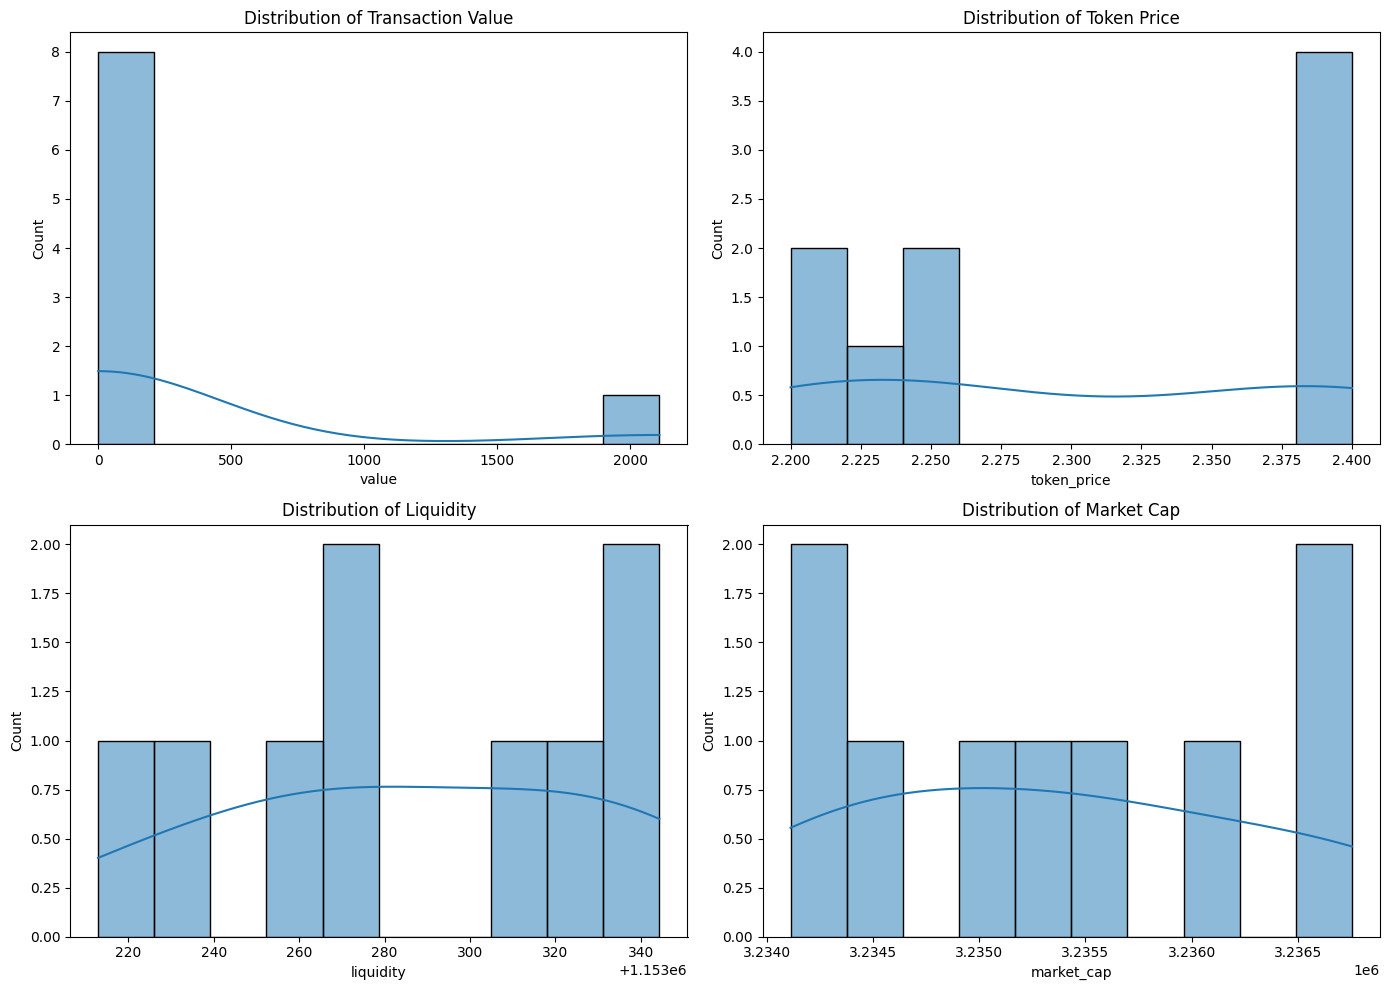

In [434]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(df['value'], bins=10, kde=True, ax=axes[0, 0]).set_title("Distribution of Transaction Value")
sns.histplot(df['token_price'], bins=10, kde=True, ax=axes[0, 1]).set_title("Distribution of Token Price")
sns.histplot(df['liquidity'], bins=10, kde=True, ax=axes[1, 0]).set_title("Distribution of Liquidity")
sns.histplot(df['market_cap'], bins=10, kde=True, ax=axes[1, 1]).set_title("Distribution of Market Cap")
plt.tight_layout()
plt.show()


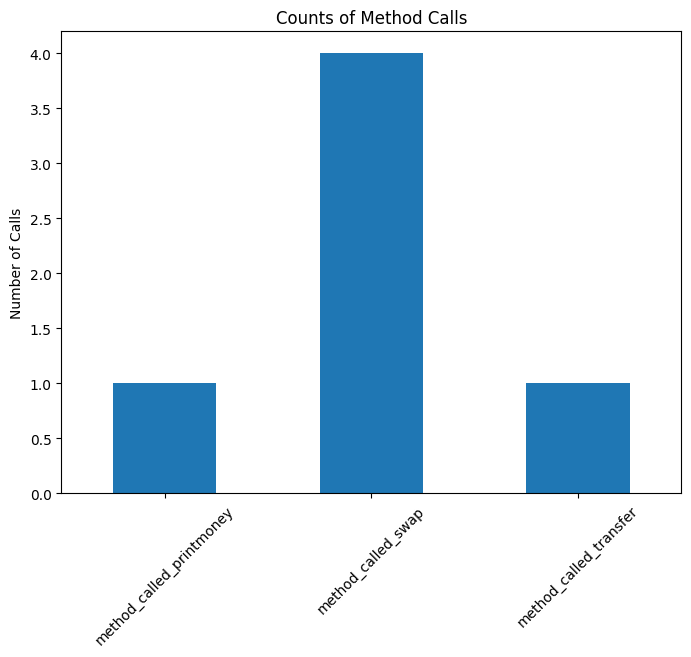

In [420]:
methods_sum = df[['method_called_printmoney', 'method_called_swap', 'method_called_transfer']].sum()
methods_sum.plot(kind='bar', figsize=(8, 6))
plt.title("Counts of Method Calls")
plt.ylabel("Number of Calls")
plt.xticks(rotation=45)
plt.show()

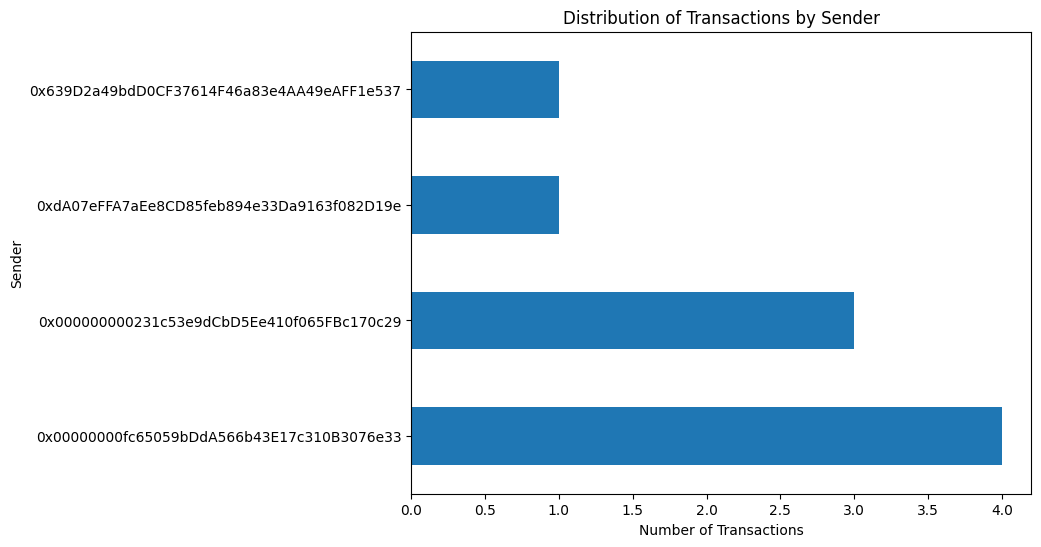

In [425]:
from_counts = df['from'].value_counts()
from_counts.plot(kind='barh', figsize=(8, 6))
plt.title("Distribution of Transactions by Sender")
plt.xlabel("Number of Transactions")
plt.ylabel("Sender")
plt.show()

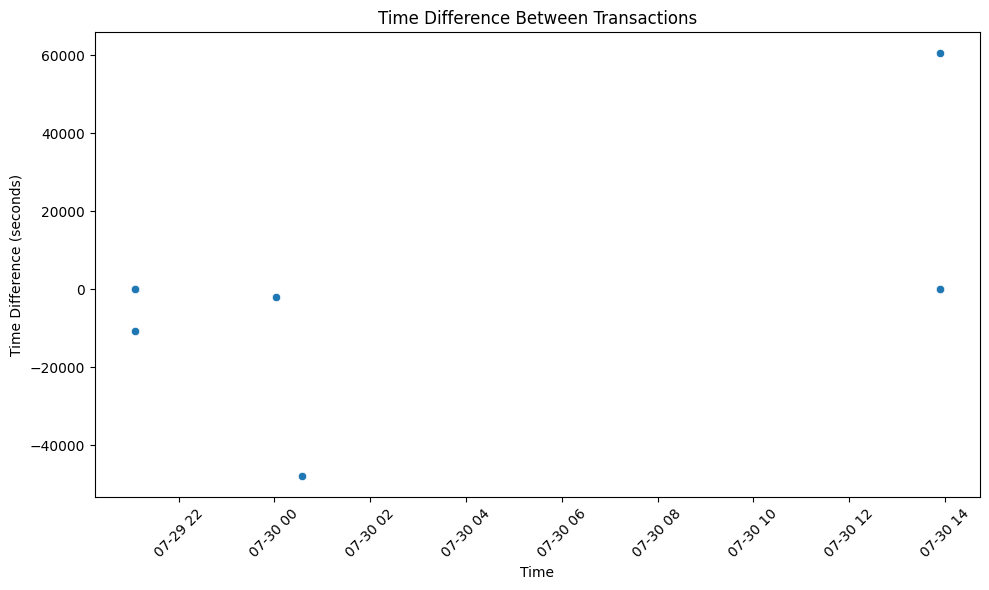

In [432]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='time_stamp', y='time_diff', data=df)
plt.title("Time Difference Between Transactions")
plt.xlabel("Time")
plt.ylabel("Time Difference (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Outliers

In [357]:
 detect_outliers(df)

,Column,Outlier Count,Outlier Percentage


There are no any outliers

### Correlation

In [358]:
df.columns

Index(['transaction_id', 'time_stamp', 'from', 'to', 'value', 'token_price',
       'liquidity', 'market_cap', 'method_called_printmoney',
       'method_called_swap', 'method_called_transfer', 'time_diff',
       'frequent_transaction_flag'],
      dtype='object')

In [359]:
df_corr = df.copy()

In [360]:
df_corr = df.copy()
df_corr.drop(columns=['transaction_id', 'time_stamp', 'from', 'to'], axis=1, inplace=True)
df_corr

,value,token_price,liquidity,market_cap,method_called_printmoney,method_called_swap,method_called_transfer,time_diff,frequent_transaction_flag
0,0.12,2.38,1153212.96,3234533.45,0,0,0,0.0,0
1,0.02,2.39,1153234.56,3235002.04,0,0,0,-1.0,1
2,2.40,2.40,1153266.32,3234113.31,0,0,0,-47938.0,0
3,5.00,2.39,1153265.16,3234323.80,0,0,1,-1935.0,0
4,3.50,2.26,1153344.33,3235421.46,0,1,0,-10627.0,0
5,3.50,2.26,1153342.55,3235532.40,0,1,0,-1.0,1
6,3.50,2.22,1153312.90,3236754.55,0,1,0,-1.0,1
7,3.50,2.20,1153319.12,3236751.09,0,1,0,-1.0,1
8,2110.00,2.21,1153278.06,3235980.11,1,0,0,60505.0,0


In [361]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   value                      9 non-null      float64
 1   token_price                9 non-null      float64
 2   liquidity                  9 non-null      float64
 3   market_cap                 9 non-null      float64
 4   method_called_printmoney   9 non-null      int64  
 5   method_called_swap         9 non-null      int64  
 6   method_called_transfer     9 non-null      int64  
 7   time_diff                  9 non-null      float64
 8   frequent_transaction_flag  9 non-null      int64  
dtypes: float64(5), int64(4)
memory usage: 776.0 bytes


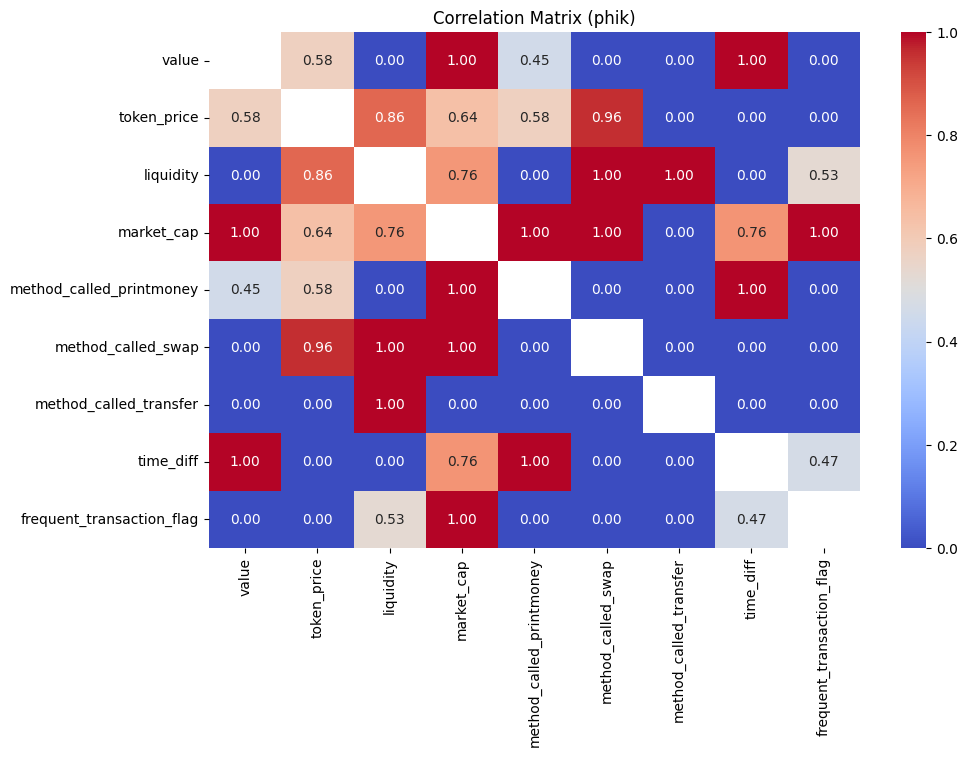

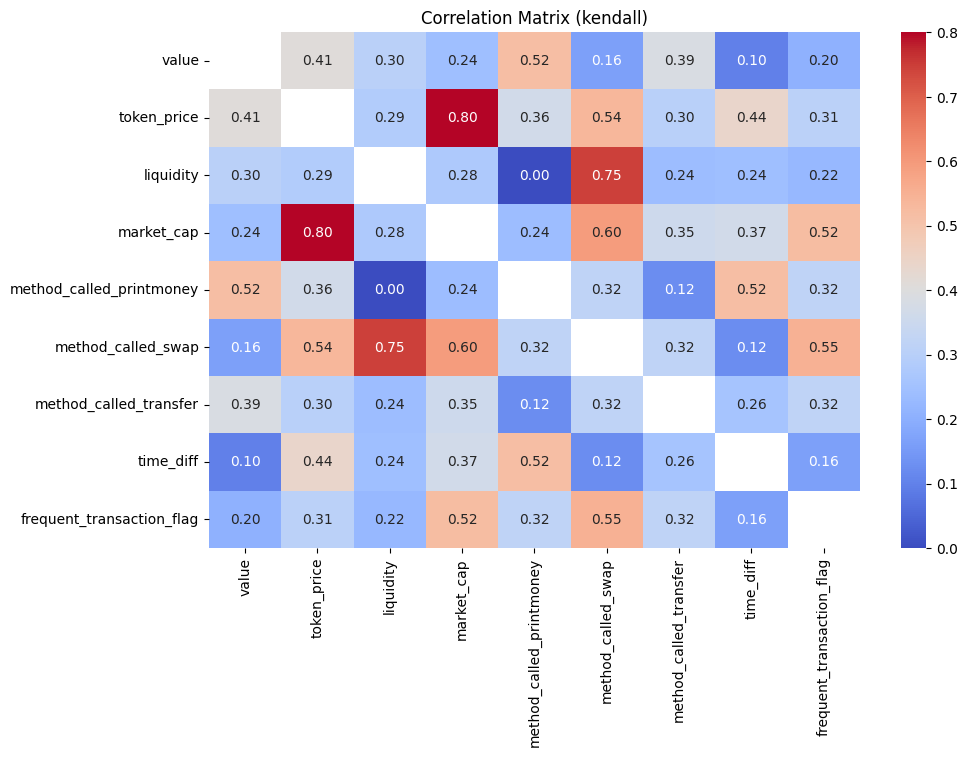


Multicollinearity Table (phik)


,Feature 1,Feature 2,Correlation
0,value,market_cap,1.000000
1,value,time_diff,1.000000
4,liquidity,method_called_swap,1.000000
5,liquidity,method_called_transfer,1.000000
6,market_cap,method_called_printmoney,1.000000
7,market_cap,method_called_swap,1.000000
8,market_cap,frequent_transaction_flag,1.000000
9,method_called_printmoney,time_diff,1.000000
3,token_price,method_called_swap,0.957474
2,token_price,liquidity,0.860136



Multicollinearity Table (kendall)


,Feature 1,Feature 2,Correlation
0,token_price,market_cap,0.800327


In [362]:
find_multicollinearity(df_corr, methods=['phik', 'kendall'], threshold=0.8)

The data shows clear multicollinearity between features 'token_price'	and 'market_cap'. Let's remove these features from the training data.

# Train

In [244]:
# Create a copy of the original dataframe for training
df_train = df.copy()

min_large_transaction_threshold = df['value'].quantile(0.5)

# Simple label for abnormal transactions by volume and number of transactions from one account
df_train['label'] = (((df['value'] > df['value'].quantile(0.95)) & (df['value'] > min_large_transaction_threshold)) | (df['frequent_transaction_flag'] == 1)).astype(int)
df_train

,transaction_id,time_stamp,from,to,value,token_price,liquidity,market_cap,method_called_printmoney,method_called_swap,method_called_transfer,time_diff,frequent_transaction_flag,label
0,0xf04403e162a8a988780de9a0416f8b87633e71435f03...,2024-07-30 13:53:37,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.12,2.38,1153212.96,3234533.45,0,0,0,0.0,0,0
1,0x5fb4348e6ef84249f12ec5058e373e956d95913dcdec...,2024-07-30 13:53:36,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.02,2.39,1153234.56,3235002.04,0,0,0,-1.0,1,1
2,0x1bf427e14853d650e332b6188962e1ea3b21c02492e2...,2024-07-30 00:34:38,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,2.40,2.40,1153266.32,3234113.31,0,0,0,-47938.0,0,0
3,0x737bb2b517312cd2166bacb41daf5c1a80e560d3f0c8...,2024-07-30 00:02:23,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,5.00,2.39,1153265.16,3234323.80,0,0,1,-1935.0,0,0
4,0x94002f1eabc5b491f9f143bd761ff693362c25e2832f...,2024-07-29 21:05:16,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.26,1153344.33,3235421.46,0,1,0,-10627.0,0,0
5,0xe4ecd37edb93d22eef32f62dcb397f23f75b699a0c53...,2024-07-29 21:05:15,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.26,1153342.55,3235532.40,0,1,0,-1.0,1,1
6,0x0232c4dd9f4b88222ed95a25f6236d7dc25b9d3dccb9...,2024-07-29 21:05:14,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.22,1153312.90,3236754.55,0,1,0,-1.0,1,1
7,0xc5061da6f7c89ab0fc20c912f058636a8c3f9d8b0456...,2024-07-29 21:05:13,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.20,1153319.12,3236751.09,0,1,0,-1.0,1,1
8,0x34484bf7d85bc584599957718112f0dc309a45208457...,2024-07-30 13:53:38,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,2110.00,2.21,1153278.06,3235980.11,1,0,0,60505.0,0,1


## Spliting

In [245]:
df_train.columns

Index(['transaction_id', 'time_stamp', 'from', 'to', 'value', 'token_price',
       'liquidity', 'market_cap', 'method_called_printmoney',
       'method_called_swap', 'method_called_transfer', 'time_diff',
       'frequent_transaction_flag', 'label'],
      dtype='object')

In [246]:
from sklearn.preprocessing import StandardScaler



X = df_train[['value', 'method_called_printmoney',
            'method_called_swap', 'method_called_transfer',
             'frequent_transaction_flag']]

y = df_train['label']


scaler = StandardScaler()
X = scaler.fit_transform(X)

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (9, 5)
y shape: (9,)


In [247]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
display(X_train.shape)
display(X_test.shape)

(7, 5)

(2, 5)

## BaseLines ML

In [248]:
df_train.head(2)

,transaction_id,time_stamp,from,to,value,token_price,liquidity,market_cap,method_called_printmoney,method_called_swap,method_called_transfer,time_diff,frequent_transaction_flag,label
0,0xf04403e162a8a988780de9a0416f8b87633e71435f03...,2024-07-30 13:53:37,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.12,2.38,1153212.96,3234533.45,0,0,0,0.0,0,0
1,0x5fb4348e6ef84249f12ec5058e373e956d95913dcdec...,2024-07-30 13:53:36,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.02,2.39,1153234.56,3235002.04,0,0,0,-1.0,1,1


In [249]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score, classification_report
import numpy as np


models = {
    'OneClassSVM': OneClassSVM(gamma='auto'),
    'IsolationForest': IsolationForest(random_state=42),
    'DBSCAN': DBSCAN()
}


reports = []

# Function for evaluating and calculating metrics
def evaluate_model(model, X_train, X_test, y_train, y_test):
    if isinstance(model, DBSCAN):
        y_pred = model.fit_predict(X_test)
        y_pred = (y_pred == -1).astype(int)

        # Check for number of unique marks before calculating silhouette_score
        unique_labels = np.unique(y_pred)
        if len(unique_labels) > 1:
            silhouette = silhouette_score(X_test, y_pred)
        else:
            silhouette = np.nan  # Set to NaN if there is only one label
    else:
        model.fit(X_train)
        y_pred = model.predict(X_test)
        y_pred = (y_pred == -1).astype(int)
        silhouette = np.nan


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Silhouette Score': silhouette
    }

# Model evaluation
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
    metrics['Model'] = model_name
    reports.append(metrics)

results_df = pd.DataFrame(reports)
display(results_df)

Evaluating OneClassSVM...
Evaluating IsolationForest...
Evaluating DBSCAN...


,Accuracy,Precision,Recall,F1 Score,Silhouette Score,Model
0,0.5,0.5,1.0,0.666667,NaN,OneClassSVM
1,0.5,0.0,0.0,0.000000,NaN,IsolationForest
2,0.5,0.5,1.0,0.666667,NaN,DBSCAN


Due to lack of data, the models are unable to learn. Let's continue training within the theoretical framework.

## OneClassSVM

In [250]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score
from sklearn.model_selection import KFold
import numpy as np



# Initsializatsiya kross-validatsii
kf = KFold(n_splits=5, shuffle=True, random_state=42)


accuracy_scores, precision_scores, recall_scores, f1_scores, silhouette_scores = [], [], [], [], []

for train_index, val_index in kf.split(X):

    X_train, X_val = X[train_index], X[val_index]
    y_val = y[val_index]

    # Initialize and train the model
    svm = OneClassSVM(gamma='auto')
    svm.fit(X_train)

    y_pred = (svm.predict(X_val) == -1).astype(int)

    # Calculating metrics
    accuracy_scores.append(accuracy_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred, zero_division=0))
    recall_scores.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))


    # Check that the sample is not empty and contains at least 2 different classes
    if len(X_val) > 1 and len(np.unique(y_pred)) > 1:
        try:
            silhouette_scores.append(silhouette_score(X_val, y_pred))
        except ValueError:
            silhouette_scores.append(0)  # If silhouette_score can't be calculated, add 0
    else:
        silhouette_scores.append(0)  # If the validation set is too small or contains one class


print("One-Class SVM Cross-Validation Results:")
print(f"Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f}")
print(f"Silhouette Score: {np.mean(silhouette_scores):.4f}")

One-Class SVM Cross-Validation Results:
Accuracy: 0.4000
Precision: 0.4000
Recall: 0.3000
F1 Score: 0.3333
Silhouette Score: 0.0000


In [251]:
from sklearn.preprocessing import MinMaxScaler

# Model training and predictions
svm = OneClassSVM(gamma='auto')
df_train['svm_anomaly'] = svm.fit_predict(X)
df_train['alert_svm'] = df_train['svm_anomaly'] == -1

# Getting distances from the hyperplane for each point
decision_scores = svm.decision_function(X)

# Normalize distance values ​​to range from 0 to 1 (for interpretation as probabilities)
scaler = MinMaxScaler(feature_range=(0, 1))
df_train['svm_confidence'] = scaler.fit_transform(decision_scores.reshape(-1, 1)).round(4)


df_train['svm_confidence'] = 1 - df_train['svm_confidence']
y_pred_svm = (df_train['svm_anomaly'] == -1).astype(int)

accuracy_svm = accuracy_score(y.values, y_pred_svm)
precision_svm = precision_score(df_train['label'], y_pred_svm, zero_division=0)
recall_svm = recall_score(df_train['label'], y_pred_svm)
f1_svm = f1_score(df_train['label'], y_pred_svm)
silhouette_svm = silhouette_score(X, y_pred_svm)

print(f"One-Class SVM Results:\n Accuracy: {accuracy_svm}, Precision: {precision_svm}, Recall: {recall_svm}, F1 Score: {f1_svm}, Silhouette Score: {silhouette_svm}")
df_train

One-Class SVM Results:
 Accuracy: 0.7777777777777778, Precision: 0.7142857142857143, Recall: 1.0, F1 Score: 0.8333333333333334, Silhouette Score: -0.05823613290142307


,transaction_id,time_stamp,from,to,value,token_price,liquidity,market_cap,method_called_printmoney,method_called_swap,method_called_transfer,time_diff,frequent_transaction_flag,label,svm_anomaly,alert_svm,svm_confidence
0,0xf04403e162a8a988780de9a0416f8b87633e71435f03...,2024-07-30 13:53:37,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.12,2.38,1153212.96,3234533.45,0,0,0,0.0,0,0,-1,True,0.0008
1,0x5fb4348e6ef84249f12ec5058e373e956d95913dcdec...,2024-07-30 13:53:36,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.02,2.39,1153234.56,3235002.04,0,0,0,-1.0,1,1,-1,True,0.0008
2,0x1bf427e14853d650e332b6188962e1ea3b21c02492e2...,2024-07-30 00:34:38,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,2.40,2.40,1153266.32,3234113.31,0,0,0,-47938.0,0,0,1,False,0.0006
3,0x737bb2b517312cd2166bacb41daf5c1a80e560d3f0c8...,2024-07-30 00:02:23,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,5.00,2.39,1153265.16,3234323.80,0,0,1,-1935.0,0,0,-1,True,0.6065
4,0x94002f1eabc5b491f9f143bd761ff693362c25e2832f...,2024-07-29 21:05:16,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.26,1153344.33,3235421.46,0,1,0,-10627.0,0,0,1,False,0.0000
5,0xe4ecd37edb93d22eef32f62dcb397f23f75b699a0c53...,2024-07-29 21:05:15,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.26,1153342.55,3235532.40,0,1,0,-1.0,1,1,-1,True,0.0017
6,0x0232c4dd9f4b88222ed95a25f6236d7dc25b9d3dccb9...,2024-07-29 21:05:14,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.22,1153312.90,3236754.55,0,1,0,-1.0,1,1,-1,True,0.0017
7,0xc5061da6f7c89ab0fc20c912f058636a8c3f9d8b0456...,2024-07-29 21:05:13,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.20,1153319.12,3236751.09,0,1,0,-1.0,1,1,-1,True,0.0017
8,0x34484bf7d85bc584599957718112f0dc309a45208457...,2024-07-30 13:53:38,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,2110.00,2.21,1153278.06,3235980.11,1,0,0,60505.0,0,1,-1,True,1.0000


Let's try to find the optimal parameters

In [252]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.svm import OneClassSVM

def svm_objective(params):
    model = OneClassSVM(**params)
    model.fit(X)
    preds = model.predict(X)
    y_pred = (preds == -1).astype(int)
    f1 = f1_score(y, y_pred)
    return {'loss': -f1, 'status': STATUS_OK}

svm_space = {
    'nu': hp.uniform('nu', 0.01, 0.9),
    'gamma': hp.choice('gamma', ['scale', 'auto', 0.1, 0.01]),
    'kernel': hp.choice('kernel', ['rbf', 'sigmoid'])
}

trials = Trials()
best_svm_params = fmin(svm_objective, svm_space, algo=tpe.suggest, max_evals=50, trials=trials)
print(f"Best SVM Parameters from Hyperopt: {best_svm_params}")

100%|██████████| 50/50 [00:00<00:00, 123.59trial/s, best loss: -0.9090909090909091]
Best SVM Parameters from Hyperopt: {'gamma': 0, 'kernel': 0, 'nu': 0.26035642528889213}


Best SVM Parameters from Hyperopt: {'gamma': 2, 'kernel': 1, 'nu': 0.5289741815767469}

In [253]:
best_svm_params = {
    'nu': best_svm_params['nu'],
    'gamma': ['scale', 'auto', 0.1, 0.01][best_svm_params['gamma']],
    'kernel': ['rbf', 'sigmoid'][best_svm_params['kernel']]
}

In [254]:
# Final training and evaluation
svm = OneClassSVM(**best_svm_params)
df_train['svm_anomaly'] = svm.fit_predict(X)
df_train['alert_svm'] = df_train['svm_anomaly'] == -1

decision_scores = svm.decision_function(X)
scaler = MinMaxScaler(feature_range=(0, 1))
df_train['svm_confidence'] = scaler.fit_transform(decision_scores.reshape(-1, 1)).round(4)

df_train['svm_confidence'] = 1 - df_train['svm_confidence']

y_pred_svm = (df_train['svm_anomaly'] == -1).astype(int)

accuracy_svm = accuracy_score(y.values, y_pred_svm)
precision_svm = precision_score(df_train['label'], y_pred_svm, zero_division=0)
recall_svm = recall_score(df_train['label'], y_pred_svm)
f1_svm = f1_score(df_train['label'], y_pred_svm)
silhouette_svm = silhouette_score(X, y_pred_svm)

print(f"One-Class SVM Results:\n Accuracy: {accuracy_svm}, Precision: {precision_svm}, Recall: {recall_svm}, F1 Score: {f1_svm}, Silhouette Score: {silhouette_svm}")
df_train

One-Class SVM Results:
 Accuracy: 0.8888888888888888, Precision: 0.8333333333333334, Recall: 1.0, F1 Score: 0.9090909090909091, Silhouette Score: 0.25200735702679283


,transaction_id,time_stamp,from,to,value,token_price,liquidity,market_cap,method_called_printmoney,method_called_swap,method_called_transfer,time_diff,frequent_transaction_flag,label,svm_anomaly,alert_svm,svm_confidence
0,0xf04403e162a8a988780de9a0416f8b87633e71435f03...,2024-07-30 13:53:37,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.12,2.38,1153212.96,3234533.45,0,0,0,0.0,0,0,1,False,0.0775
1,0x5fb4348e6ef84249f12ec5058e373e956d95913dcdec...,2024-07-30 13:53:36,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.02,2.39,1153234.56,3235002.04,0,0,0,-1.0,1,1,-1,True,0.9989
2,0x1bf427e14853d650e332b6188962e1ea3b21c02492e2...,2024-07-30 00:34:38,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,2.40,2.40,1153266.32,3234113.31,0,0,0,-47938.0,0,0,1,False,0.0000
3,0x737bb2b517312cd2166bacb41daf5c1a80e560d3f0c8...,2024-07-30 00:02:23,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,5.00,2.39,1153265.16,3234323.80,0,0,1,-1935.0,0,0,1,False,0.4066
4,0x94002f1eabc5b491f9f143bd761ff693362c25e2832f...,2024-07-29 21:05:16,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.26,1153344.33,3235421.46,0,1,0,-10627.0,0,0,-1,True,0.9630
5,0xe4ecd37edb93d22eef32f62dcb397f23f75b699a0c53...,2024-07-29 21:05:15,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.26,1153342.55,3235532.40,0,1,0,-1.0,1,1,-1,True,0.9989
6,0x0232c4dd9f4b88222ed95a25f6236d7dc25b9d3dccb9...,2024-07-29 21:05:14,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.22,1153312.90,3236754.55,0,1,0,-1.0,1,1,-1,True,0.9989
7,0xc5061da6f7c89ab0fc20c912f058636a8c3f9d8b0456...,2024-07-29 21:05:13,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.20,1153319.12,3236751.09,0,1,0,-1.0,1,1,-1,True,0.9989
8,0x34484bf7d85bc584599957718112f0dc309a45208457...,2024-07-30 13:53:38,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,2110.00,2.21,1153278.06,3235980.11,1,0,0,60505.0,0,1,-1,True,1.0000


In [255]:
# Save the model
import joblib

joblib.dump(svm, 'svm_model.pkl')

df_train.to_csv('svm_results.csv', index=False)

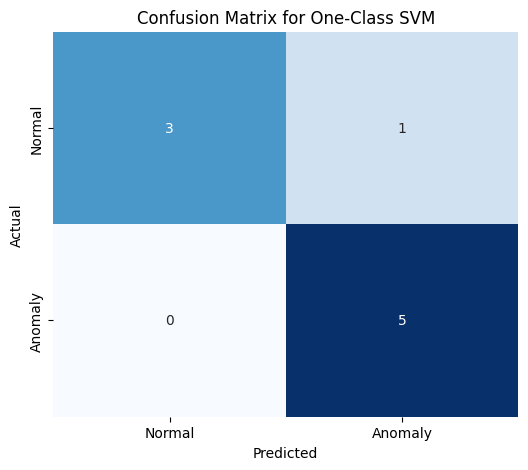

In [256]:
# Visualize the confusion matrix for One-Class SVM

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred_svm = (df_train['svm_anomaly'] == -1).astype(int)


conf_matrix_svm = confusion_matrix(y, y_pred_svm)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix for One-Class SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## IsolationForest

In [257]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores, precision_scores, recall_scores, f1_scores, silhouette_scores = [], [], [], [], []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_val = y[val_index]


    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train)

    y_pred = (iso_forest.predict(X_val) == -1).astype(int)

    accuracy_scores.append(accuracy_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred, zero_division=0))
    recall_scores.append(recall_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))

    if len(X_val) > 1 and len(np.unique(y_pred)) > 1:
        try:
            silhouette_scores.append(silhouette_score(X_val, y_pred))
        except ValueError:
            silhouette_scores.append(0)
    else:
        silhouette_scores.append(0)

print("IsolationForest Cross-Validation Results:")
print(f"Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f}")
print(f"Silhouette Score: {np.mean(silhouette_scores):.4f}")

IsolationForest Cross-Validation Results:
Accuracy: 0.3000
Precision: 0.1000
Recall: 0.2000
F1 Score: 0.1333
Silhouette Score: 0.0000


In [258]:
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler


iso_forest = IsolationForest(random_state=42)
df_train['iso_forest_anomaly'] = iso_forest.fit_predict(X)
df_train['alert_iso_forest'] = df_train['iso_forest_anomaly'] == -1


iso_decision_scores = iso_forest.decision_function(X)

# Normalize decision scores to get confidence
scaler = MinMaxScaler(feature_range=(0, 1))
df_train['iso_forest_confidence'] = 1 - scaler.fit_transform(iso_decision_scores.reshape(-1, 1)).round(4)


y_pred_iso = (df_train['iso_forest_anomaly'] == -1).astype(int)
accuracy_iso = accuracy_score(y, y_pred_iso)
precision_iso = precision_score(y, y_pred_iso, zero_division=0)
recall_iso = recall_score(y, y_pred_iso)
f1_iso = f1_score(y, y_pred_iso)
silhouette_iso = silhouette_score(X, y_pred_iso)

print(f"IsolationForest Results:\n Accuracy: {accuracy_iso}, Precision: {precision_iso}, Recall: {recall_iso}, F1 Score: {f1_iso}, Silhouette Score: {silhouette_iso}")
df_train

IsolationForest Results:
 Accuracy: 0.5555555555555556, Precision: 0.6666666666666666, Recall: 0.4, F1 Score: 0.5, Silhouette Score: 0.2499280415226104


,transaction_id,time_stamp,from,to,value,token_price,liquidity,market_cap,method_called_printmoney,method_called_swap,method_called_transfer,time_diff,frequent_transaction_flag,label,svm_anomaly,alert_svm,svm_confidence,iso_forest_anomaly,alert_iso_forest,iso_forest_confidence
0,0xf04403e162a8a988780de9a0416f8b87633e71435f03...,2024-07-30 13:53:37,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.12,2.38,1153212.96,3234533.45,0,0,0,0.0,0,0,1,False,0.0775,1,False,0.0519
1,0x5fb4348e6ef84249f12ec5058e373e956d95913dcdec...,2024-07-30 13:53:36,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.02,2.39,1153234.56,3235002.04,0,0,0,-1.0,1,1,-1,True,0.9989,-1,True,0.5333
2,0x1bf427e14853d650e332b6188962e1ea3b21c02492e2...,2024-07-30 00:34:38,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,2.40,2.40,1153266.32,3234113.31,0,0,0,-47938.0,0,0,1,False,0.0000,1,False,0.0000
3,0x737bb2b517312cd2166bacb41daf5c1a80e560d3f0c8...,2024-07-30 00:02:23,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,5.00,2.39,1153265.16,3234323.80,0,0,1,-1935.0,0,0,1,False,0.4066,-1,True,0.6132
4,0x94002f1eabc5b491f9f143bd761ff693362c25e2832f...,2024-07-29 21:05:16,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.26,1153344.33,3235421.46,0,1,0,-10627.0,0,0,-1,True,0.9630,1,False,0.3604
5,0xe4ecd37edb93d22eef32f62dcb397f23f75b699a0c53...,2024-07-29 21:05:15,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.26,1153342.55,3235532.40,0,1,0,-1.0,1,1,-1,True,0.9989,1,False,0.1995
6,0x0232c4dd9f4b88222ed95a25f6236d7dc25b9d3dccb9...,2024-07-29 21:05:14,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.22,1153312.90,3236754.55,0,1,0,-1.0,1,1,-1,True,0.9989,1,False,0.1995
7,0xc5061da6f7c89ab0fc20c912f058636a8c3f9d8b0456...,2024-07-29 21:05:13,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.20,1153319.12,3236751.09,0,1,0,-1.0,1,1,-1,True,0.9989,1,False,0.1995
8,0x34484bf7d85bc584599957718112f0dc309a45208457...,2024-07-30 13:53:38,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,2110.00,2.21,1153278.06,3235980.11,1,0,0,60505.0,0,1,-1,True,1.0000,-1,True,1.0000


In [259]:
def iso_objective(params):
    model = IsolationForest(**params, random_state=42)
    model.fit(X)
    preds = model.predict(X)
    y_pred = (preds == -1).astype(int)
    f1 = f1_score(y, y_pred)
    return {'loss': -f1, 'status': STATUS_OK}

iso_space = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 150]),
    'max_samples': hp.choice('max_samples', ['auto', 0.6, 0.8]),
    'contamination': hp.choice('contamination', [0.05, 0.1, 0.15]),
    'max_features': hp.uniform('max_features', 0.5, 1.0)
}

trials = Trials()
best_iso_params = fmin(iso_objective, iso_space, algo=tpe.suggest, max_evals=50, trials=trials)
print(f"Best IsolationForest Parameters from Hyperopt: {best_iso_params}")

best_iso_params = {
    'n_estimators': [50, 100, 150][best_iso_params['n_estimators']],
    'max_samples': ['auto', 0.6, 0.8][best_iso_params['max_samples']],
    'contamination': [0.05, 0.1, 0.15][best_iso_params['contamination']],
    'max_features': best_iso_params['max_features']
}

100%|██████████| 50/50 [00:10<00:00,  4.80trial/s, best loss: -0.3333333333333333]
Best IsolationForest Parameters from Hyperopt: {'contamination': 0, 'max_features': 0.6939434471791197, 'max_samples': 1, 'n_estimators': 0}


In [260]:
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

iso_forest = IsolationForest(**best_iso_params, random_state=42)
df_train['iso_forest_anomaly'] = iso_forest.fit_predict(X)
df_train['alert_iso_forest'] = df_train['iso_forest_anomaly'] == -1

iso_decision_scores = iso_forest.decision_function(X)

scaler = MinMaxScaler(feature_range=(0, 1))
df_train['iso_forest_confidence'] = 1 - scaler.fit_transform(iso_decision_scores.reshape(-1, 1)).round(4)

y_pred_iso = (df_train['iso_forest_anomaly'] == -1).astype(int)
accuracy_iso = accuracy_score(y, y_pred_iso)
precision_iso = precision_score(y, y_pred_iso, zero_division=0)
recall_iso = recall_score(y, y_pred_iso)
f1_iso = f1_score(y, y_pred_iso)
silhouette_iso = silhouette_score(X, y_pred_iso)

print(f"IsolationForest Results:\n Accuracy: {accuracy_iso}, Precision: {precision_iso}, Recall: {recall_iso}, F1 Score: {f1_iso}, Silhouette Score: {silhouette_iso}")
df_train

IsolationForest Results:
 Accuracy: 0.5555555555555556, Precision: 1.0, Recall: 0.2, F1 Score: 0.3333333333333333, Silhouette Score: 0.46843899201398753


,transaction_id,time_stamp,from,to,value,token_price,liquidity,market_cap,method_called_printmoney,method_called_swap,method_called_transfer,time_diff,frequent_transaction_flag,label,svm_anomaly,alert_svm,svm_confidence,iso_forest_anomaly,alert_iso_forest,iso_forest_confidence
0,0xf04403e162a8a988780de9a0416f8b87633e71435f03...,2024-07-30 13:53:37,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.12,2.38,1153212.96,3234533.45,0,0,0,0.0,0,0,1,False,0.0775,1,False,0.2080
1,0x5fb4348e6ef84249f12ec5058e373e956d95913dcdec...,2024-07-30 13:53:36,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.02,2.39,1153234.56,3235002.04,0,0,0,-1.0,1,1,-1,True,0.9989,1,False,0.4277
2,0x1bf427e14853d650e332b6188962e1ea3b21c02492e2...,2024-07-30 00:34:38,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,2.40,2.40,1153266.32,3234113.31,0,0,0,-47938.0,0,0,1,False,0.0000,1,False,0.0000
3,0x737bb2b517312cd2166bacb41daf5c1a80e560d3f0c8...,2024-07-30 00:02:23,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,5.00,2.39,1153265.16,3234323.80,0,0,1,-1935.0,0,0,1,False,0.4066,1,False,0.5019
4,0x94002f1eabc5b491f9f143bd761ff693362c25e2832f...,2024-07-29 21:05:16,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.26,1153344.33,3235421.46,0,1,0,-10627.0,0,0,-1,True,0.9630,1,False,0.2912
5,0xe4ecd37edb93d22eef32f62dcb397f23f75b699a0c53...,2024-07-29 21:05:15,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.26,1153342.55,3235532.40,0,1,0,-1.0,1,1,-1,True,0.9989,1,False,0.2207
6,0x0232c4dd9f4b88222ed95a25f6236d7dc25b9d3dccb9...,2024-07-29 21:05:14,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.22,1153312.90,3236754.55,0,1,0,-1.0,1,1,-1,True,0.9989,1,False,0.2207
7,0xc5061da6f7c89ab0fc20c912f058636a8c3f9d8b0456...,2024-07-29 21:05:13,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.20,1153319.12,3236751.09,0,1,0,-1.0,1,1,-1,True,0.9989,1,False,0.2207
8,0x34484bf7d85bc584599957718112f0dc309a45208457...,2024-07-30 13:53:38,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,2110.00,2.21,1153278.06,3235980.11,1,0,0,60505.0,0,1,-1,True,1.0000,-1,True,1.0000


In [261]:
import joblib

joblib.dump(iso_forest, 'iso_forest_model.pkl')
df_train.to_csv('iso_forest_results.csv', index=False)

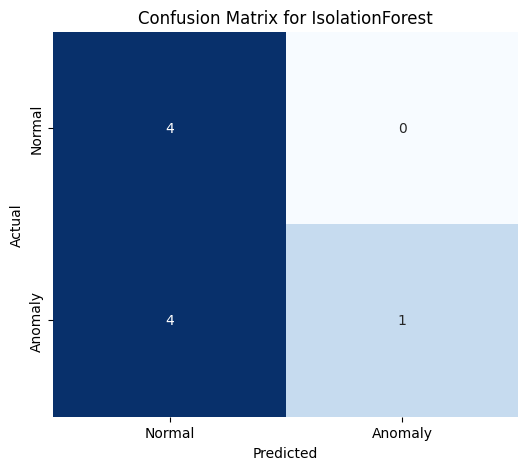

In [262]:
y_pred_iso = (df_train['iso_forest_anomaly'] == -1).astype(int)

conf_matrix_iso = confusion_matrix(y, y_pred_iso)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_iso, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix for IsolationForest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## DBSCAN

In [263]:
X = df_train[['value', 'method_called_printmoney',
            'method_called_swap', 'method_called_transfer', 'time_diff',
             'frequent_transaction_flag']]

y = df_train['label']


scaler = StandardScaler()
X = scaler.fit_transform(X)

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (9, 6)
y shape: (9,)


In [264]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score
from sklearn.model_selection import KFold
import numpy as np



warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores, precision_scores, recall_scores, f1_scores, silhouette_scores = [], [], [], [], []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_val = y[val_index]

    dbscan = DBSCAN()
    dbscan_labels = dbscan.fit_predict(X_train)

    dbscan_val_labels = dbscan.fit_predict(X_val)
    dbscan_anomaly = (dbscan_val_labels == -1).astype(int)

    accuracy_scores.append(accuracy_score(y_val, dbscan_anomaly))
    precision_scores.append(precision_score(y_val, dbscan_anomaly, zero_division=0))
    recall_scores.append(recall_score(y_val, dbscan_anomaly))
    f1_scores.append(f1_score(y_val, dbscan_anomaly))

    if len(X_val) > 1 and len(np.unique(dbscan_val_labels)) > 1:
        try:
            silhouette_scores.append(silhouette_score(X_val, dbscan_val_labels))
        except ValueError:
            silhouette_scores.append(0)
    else:
        silhouette_scores.append(0)

# Средние значения метрик
print("DBSCAN Cross-Validation Results:")
print(f"Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f}")
print(f"Silhouette Score: {np.mean(silhouette_scores):.4f}")


DBSCAN Cross-Validation Results:
Accuracy: 0.6000
Precision: 0.6000
Recall: 0.8000
F1 Score: 0.6667
Silhouette Score: 0.0000


In [265]:
dbscan = DBSCAN()
dbscan_labels = dbscan.fit_predict(X)
df_train['dbscan_anomaly'] = (dbscan_labels == -1).astype(int)
df_train['alert_dbscan'] = df_train['dbscan_anomaly'] == 1

# DBSCAN confidence approximation (0 for core points, 1 for noise)
dbscan_distances = dbscan.labels_
dbscan_confidence = (dbscan_labels == -1).astype(int)
df_train['dbscan_confidence'] = dbscan_confidence

# Metrics for DBSCAN
accuracy_dbscan = accuracy_score(y, df_train['dbscan_anomaly'])
precision_dbscan = precision_score(y, df_train['dbscan_anomaly'], zero_division=0)
recall_dbscan = recall_score(y, df_train['dbscan_anomaly'])
f1_dbscan = f1_score(y, df_train['dbscan_anomaly'])
silhouette_dbscan = silhouette_score(X, dbscan_labels, metric='euclidean') if len(set(dbscan_labels)) > 1 else float('nan')

# Print results for DBSCAN
print(f"DBSCAN Results:\n Accuracy: {accuracy_dbscan}, Precision: {precision_dbscan}, Recall: {recall_dbscan}, F1 Score: {f1_dbscan}, Silhouette Score: {silhouette_dbscan}")

# Display DataFrame with anomaly predictions and confidence scores
df_train

DBSCAN Results:
 Accuracy: 0.5555555555555556, Precision: 0.5555555555555556, Recall: 1.0, F1 Score: 0.7142857142857143, Silhouette Score: nan


,transaction_id,time_stamp,from,to,value,token_price,liquidity,market_cap,method_called_printmoney,method_called_swap,...,label,svm_anomaly,alert_svm,svm_confidence,iso_forest_anomaly,alert_iso_forest,iso_forest_confidence,dbscan_anomaly,alert_dbscan,dbscan_confidence
0,0xf04403e162a8a988780de9a0416f8b87633e71435f03...,2024-07-30 13:53:37,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.12,2.38,1153212.96,3234533.45,0,0,...,0,1,False,0.0775,1,False,0.2080,1,True,1
1,0x5fb4348e6ef84249f12ec5058e373e956d95913dcdec...,2024-07-30 13:53:36,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.02,2.39,1153234.56,3235002.04,0,0,...,1,-1,True,0.9989,1,False,0.4277,1,True,1
2,0x1bf427e14853d650e332b6188962e1ea3b21c02492e2...,2024-07-30 00:34:38,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,2.40,2.40,1153266.32,3234113.31,0,0,...,0,1,False,0.0000,1,False,0.0000,1,True,1
3,0x737bb2b517312cd2166bacb41daf5c1a80e560d3f0c8...,2024-07-30 00:02:23,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,5.00,2.39,1153265.16,3234323.80,0,0,...,0,1,False,0.4066,1,False,0.5019,1,True,1
4,0x94002f1eabc5b491f9f143bd761ff693362c25e2832f...,2024-07-29 21:05:16,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.26,1153344.33,3235421.46,0,1,...,0,-1,True,0.9630,1,False,0.2912,1,True,1
5,0xe4ecd37edb93d22eef32f62dcb397f23f75b699a0c53...,2024-07-29 21:05:15,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.26,1153342.55,3235532.40,0,1,...,1,-1,True,0.9989,1,False,0.2207,1,True,1
6,0x0232c4dd9f4b88222ed95a25f6236d7dc25b9d3dccb9...,2024-07-29 21:05:14,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.22,1153312.90,3236754.55,0,1,...,1,-1,True,0.9989,1,False,0.2207,1,True,1
7,0xc5061da6f7c89ab0fc20c912f058636a8c3f9d8b0456...,2024-07-29 21:05:13,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.20,1153319.12,3236751.09,0,1,...,1,-1,True,0.9989,1,False,0.2207,1,True,1
8,0x34484bf7d85bc584599957718112f0dc309a45208457...,2024-07-30 13:53:38,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,2110.00,2.21,1153278.06,3235980.11,1,0,...,1,-1,True,1.0000,-1,True,1.0000,1,True,1


In [266]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


def dbscan_objective(params):

    # Parameters eps and min_samples are now taken from the ranges specified in hyperopt
    eps_value = params['eps']
    # Ensure min_samples is an integer
    min_samples_value = int(params['min_samples'])

    model = DBSCAN(eps=eps_value, min_samples=min_samples_value)
    preds = model.fit_predict(X)

    # Check how many clusters were obtained
    if len(set(preds)) > 1:  # If more than 1 unique cluster (not all points are anomalies)
        sil_score = silhouette_score(X, preds)  # Calculate Silhouette Score
    else:
        sil_score = -1  # If all points become anomalies, return a very low score

    return {'loss': -sil_score, 'status': STATUS_OK}  # Return a negative value, as fmin minimizes

# Define the hyperparameter space for optimization using ranges
dbscan_space = {
    'eps': hp.uniform('eps', 0.1, 1.0),
    'min_samples': hp.quniform('min_samples', 3, 20, 1),
}


trials = Trials()


best_dbscan_params = fmin(dbscan_objective, dbscan_space, algo=tpe.suggest, max_evals=50, trials=trials)

best_dbscan_params['min_samples'] = int(best_dbscan_params['min_samples'])

# Print the best parameters for DBSCAN
print(f"Best DBSCAN Parameters from Hyperopt: {best_dbscan_params}")

dbscan = DBSCAN(**best_dbscan_params)
df_train['dbscan_anomaly'] = dbscan.fit_predict(X)
df_train['alert_dbscan'] = df_train['dbscan_anomaly'] == -1

100%|██████████| 50/50 [00:00<00:00, 102.24trial/s, best loss: -0.25461603447391346]
Best DBSCAN Parameters from Hyperopt: {'eps': 0.5629071503574065, 'min_samples': 3}


In [267]:
from sklearn.neighbors import NearestNeighbors
import numpy as np


dbscan = DBSCAN(**best_dbscan_params)
dbscan_labels = dbscan.fit_predict(X)

# denote anomalies (cluster - label 1), normal points (noize) - label 1
df_train['dbscan_anomaly'] = (dbscan_labels == 0).astype(int)
df_train['alert_dbscan'] = df_train['dbscan_anomaly'] == 1


# For cluster points the confidence coefficient will be close to 1, for noise - close to 0
if len(set(dbscan_labels)) > 1:
    # Находим ближайших соседей для всех точек
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
    distances, _ = nbrs.kneighbors(X)

    # For points that are part of clusters (dbscan_labels == 0), the confidence factor should be close to 1
    # For anomalous points (dbscan_labels == -1), the confidence factor should be close to 0
    dbscan_confidence = np.where(dbscan_labels == 0, 1 - (distances[:, 1] / distances[:, 1].max()), 0)

    # Normalize the values ​​so that the confidence coefficient is within the range [0, 1]
    dbscan_confidence = (dbscan_confidence - dbscan_confidence.min()) / (dbscan_confidence.max() - dbscan_confidence.min())
else:
    dbscan_confidence = np.zeros(len(X)) # If all points are considered noise, set the confidence factor to 0 for all


df_train['dbscan_confidence'] = dbscan_confidence

accuracy_dbscan = accuracy_score(y, df_train['dbscan_anomaly'])
precision_dbscan = precision_score(y, df_train['dbscan_anomaly'], zero_division=0)
recall_dbscan = recall_score(y, df_train['dbscan_anomaly'])
f1_dbscan = f1_score(y, df_train['dbscan_anomaly'])
silhouette_dbscan = silhouette_score(X, dbscan_labels, metric='euclidean') if len(set(dbscan_labels)) > 1 else float('nan')

print(f"DBSCAN Results:\n Accuracy: {accuracy_dbscan}, Precision: {precision_dbscan}, Recall: {recall_dbscan}, F1 Score: {f1_dbscan}, Silhouette Score: {silhouette_dbscan}")
df_train

DBSCAN Results:
 Accuracy: 0.7777777777777778, Precision: 1.0, Recall: 0.6, F1 Score: 0.75, Silhouette Score: 0.25461603447391346


,transaction_id,time_stamp,from,to,value,token_price,liquidity,market_cap,method_called_printmoney,method_called_swap,...,label,svm_anomaly,alert_svm,svm_confidence,iso_forest_anomaly,alert_iso_forest,iso_forest_confidence,dbscan_anomaly,alert_dbscan,dbscan_confidence
0,0xf04403e162a8a988780de9a0416f8b87633e71435f03...,2024-07-30 13:53:37,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.12,2.38,1153212.96,3234533.45,0,0,...,0,1,False,0.0775,1,False,0.2080,0,False,0.0
1,0x5fb4348e6ef84249f12ec5058e373e956d95913dcdec...,2024-07-30 13:53:36,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.02,2.39,1153234.56,3235002.04,0,0,...,1,-1,True,0.9989,1,False,0.4277,0,False,0.0
2,0x1bf427e14853d650e332b6188962e1ea3b21c02492e2...,2024-07-30 00:34:38,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,2.40,2.40,1153266.32,3234113.31,0,0,...,0,1,False,0.0000,1,False,0.0000,0,False,0.0
3,0x737bb2b517312cd2166bacb41daf5c1a80e560d3f0c8...,2024-07-30 00:02:23,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,5.00,2.39,1153265.16,3234323.80,0,0,...,0,1,False,0.4066,1,False,0.5019,0,False,0.0
4,0x94002f1eabc5b491f9f143bd761ff693362c25e2832f...,2024-07-29 21:05:16,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.26,1153344.33,3235421.46,0,1,...,0,-1,True,0.9630,1,False,0.2912,0,False,0.0
5,0xe4ecd37edb93d22eef32f62dcb397f23f75b699a0c53...,2024-07-29 21:05:15,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.26,1153342.55,3235532.40,0,1,...,1,-1,True,0.9989,1,False,0.2207,1,True,1.0
6,0x0232c4dd9f4b88222ed95a25f6236d7dc25b9d3dccb9...,2024-07-29 21:05:14,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.22,1153312.90,3236754.55,0,1,...,1,-1,True,0.9989,1,False,0.2207,1,True,1.0
7,0xc5061da6f7c89ab0fc20c912f058636a8c3f9d8b0456...,2024-07-29 21:05:13,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.20,1153319.12,3236751.09,0,1,...,1,-1,True,0.9989,1,False,0.2207,1,True,1.0
8,0x34484bf7d85bc584599957718112f0dc309a45208457...,2024-07-30 13:53:38,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,2110.00,2.21,1153278.06,3235980.11,1,0,...,1,-1,True,1.0000,-1,True,1.0000,0,False,0.0


In this case, DVBSCAN can be used in reverse order: the model identifies clusters in which transactions with a small interval of operations are located.These transactions may be made by bots, or they may well be fraudulent transfers.

In [268]:
import joblib

joblib.dump(dbscan, 'dbscan_model.pkl')

df_train.to_csv('dbscan_results.csv', index=False)

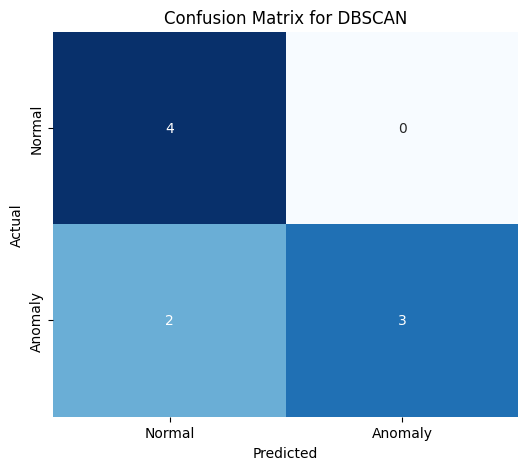

In [269]:
y_pred_dbscan = df_train['dbscan_anomaly']
conf_matrix_dbscan = confusion_matrix(y, y_pred_dbscan)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_dbscan, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix for DBSCAN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Autoencoder Neural Network

In [270]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import KFold

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [271]:
# Model initialization
model = Autoencoder(input_dim=X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Cross-validation evaluation
results_df, all_train_losses, all_val_losses = cross_val_evaluate(model, X, y, optimizer, loss_fn, n_splits=5, epochs=50, device=device)

# Combine results with original dataframe
df_train['autoencoder_anomaly'] = results_df['label'].values
df_train['autoencoder_confidence'] = results_df['confidence'].values

df_train

Fold 1/5
Epoch [1/50], Train Loss: 1.1865, Val Loss: 0.3970
Epoch [2/50], Train Loss: 1.1718, Val Loss: 0.4001
Epoch [3/50], Train Loss: 1.1586, Val Loss: 0.4040
Epoch [4/50], Train Loss: 1.1461, Val Loss: 0.4078
Epoch [5/50], Train Loss: 1.1345, Val Loss: 0.4115
Epoch [6/50], Train Loss: 1.1220, Val Loss: 0.4155
Epoch [7/50], Train Loss: 1.1086, Val Loss: 0.4192
Epoch [8/50], Train Loss: 1.0938, Val Loss: 0.4224
Epoch [9/50], Train Loss: 1.0770, Val Loss: 0.4251
Epoch [10/50], Train Loss: 1.0578, Val Loss: 0.4274
Epoch [11/50], Train Loss: 1.0356, Val Loss: 0.4297
Epoch [12/50], Train Loss: 1.0101, Val Loss: 0.4318
Epoch [13/50], Train Loss: 0.9804, Val Loss: 0.4340
Epoch [14/50], Train Loss: 0.9461, Val Loss: 0.4362
Epoch [15/50], Train Loss: 0.9078, Val Loss: 0.4389
Epoch [16/50], Train Loss: 0.8648, Val Loss: 0.4416
Epoch [17/50], Train Loss: 0.8166, Val Loss: 0.4445
Epoch [18/50], Train Loss: 0.7632, Val Loss: 0.4476
Epoch [19/50], Train Loss: 0.7053, Val Loss: 0.4502
Epoch [20/50

,transaction_id,time_stamp,from,to,value,token_price,liquidity,market_cap,method_called_printmoney,method_called_swap,...,alert_svm,svm_confidence,iso_forest_anomaly,alert_iso_forest,iso_forest_confidence,dbscan_anomaly,alert_dbscan,dbscan_confidence,autoencoder_anomaly,autoencoder_confidence
0,0xf04403e162a8a988780de9a0416f8b87633e71435f03...,2024-07-30 13:53:37,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.12,2.38,1153212.96,3234533.45,0,0,...,False,0.0775,1,False,0.2080,0,False,0.0,1.0,1.0
1,0x5fb4348e6ef84249f12ec5058e373e956d95913dcdec...,2024-07-30 13:53:36,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,0.02,2.39,1153234.56,3235002.04,0,0,...,True,0.9989,1,False,0.4277,0,False,0.0,1.0,1.0
2,0x1bf427e14853d650e332b6188962e1ea3b21c02492e2...,2024-07-30 00:34:38,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,2.40,2.40,1153266.32,3234113.31,0,0,...,False,0.0000,1,False,0.0000,0,False,0.0,0.0,1.0
3,0x737bb2b517312cd2166bacb41daf5c1a80e560d3f0c8...,2024-07-30 00:02:23,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,5.00,2.39,1153265.16,3234323.80,0,0,...,False,0.4066,1,False,0.5019,0,False,0.0,1.0,1.0
4,0x94002f1eabc5b491f9f143bd761ff693362c25e2832f...,2024-07-29 21:05:16,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.26,1153344.33,3235421.46,0,1,...,True,0.9630,1,False,0.2912,0,False,0.0,0.0,1.0
5,0xe4ecd37edb93d22eef32f62dcb397f23f75b699a0c53...,2024-07-29 21:05:15,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.26,1153342.55,3235532.40,0,1,...,True,0.9989,1,False,0.2207,1,True,1.0,1.0,1.0
6,0x0232c4dd9f4b88222ed95a25f6236d7dc25b9d3dccb9...,2024-07-29 21:05:14,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.22,1153312.90,3236754.55,0,1,...,True,0.9989,1,False,0.2207,1,True,1.0,0.0,1.0
7,0xc5061da6f7c89ab0fc20c912f058636a8c3f9d8b0456...,2024-07-29 21:05:13,0x00000000fc65059bDdA566b43E17c310B3076e33,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,3.50,2.20,1153319.12,3236751.09,0,1,...,True,0.9989,1,False,0.2207,1,True,1.0,0.0,1.0
8,0x34484bf7d85bc584599957718112f0dc309a45208457...,2024-07-30 13:53:38,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000041d945c46E073F0048cEf510D148dEA,2110.00,2.21,1153278.06,3235980.11,1,0,...,True,1.0000,-1,True,1.0000,0,False,0.0,1.0,0.5


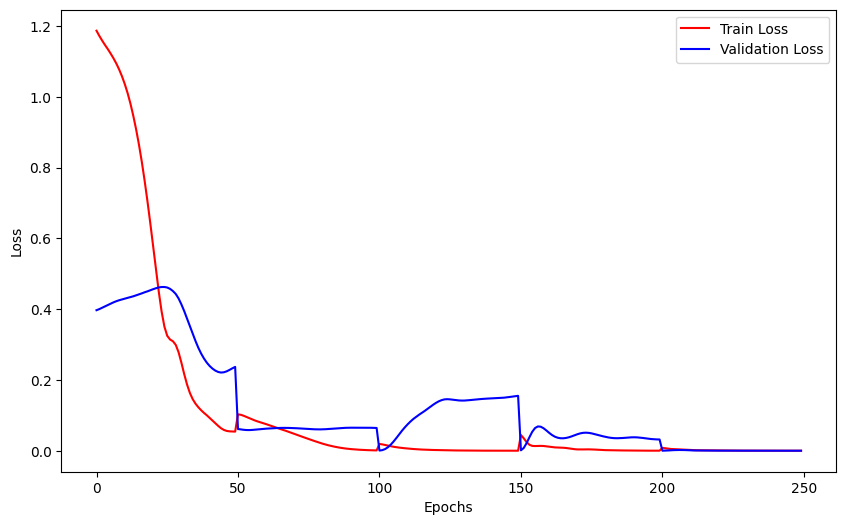

In [272]:
visualization(all_train_losses, all_val_losses)

To train a neural network, much more data is needed.

In [273]:
y_pred_autoencoder = df_train['autoencoder_anomaly']

accuracy = accuracy_score(y, y_pred_autoencoder )
precision = precision_score(y, y_pred_autoencoder )
recall = recall_score(y, y_pred_autoencoder )
f1 = f1_score(y, y_pred_autoencoder )

print(f"Accuracy: {round(accuracy, 2)}")
print(f"Precision: {round(precision, 2)}")
print(f"Recall: {round(recall, 2)}")
print(f"F1 Score: {round(f1, 2)}")

Accuracy: 0.56
Precision: 0.6
Recall: 0.6
F1 Score: 0.6


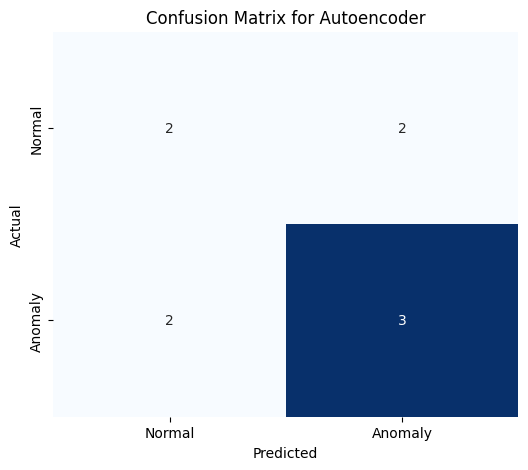

In [274]:
y_pred_autoencoder = df_train['autoencoder_anomaly']


conf_matrix_autoencoder = confusion_matrix(y, y_pred_autoencoder)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_autoencoder, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix for Autoencoder')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [275]:
torch.save(model.state_dict(), 'autoencoder_weights.pth')

# Test

In [365]:
import random
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Function to generate synthetic data
def generate_synthetic_data(num_rows=100):
    # Define basic data for repetitive transactions
    base_transaction_ids = [f"0x{''.join(random.choices('abcdef0123456789', k=64))}" for _ in range(5)]
    base_from_addresses = [f"0x{''.join(random.choices('abcdef0123456789', k=40))}" for _ in range(5)]
    base_to_addresses = [f"0x{''.join(random.choices('abcdef0123456789', k=40))}" for _ in range(5)]
    methods = ['buy', 'sell', 'swap', 'transfer', 'printMoney']

    # Generate random prices and liquidity values
    prices = np.round(np.random.uniform(2.2, 2.5, num_rows), 2)
    liquidity_values = np.round(np.random.uniform(1e6, 2e6, num_rows), 2)
    market_caps = np.round(np.random.uniform(3e6, 5e6, num_rows), 2)

    # Generate random timestamps (1 second interval between them)
    start_time = datetime(2024, 7, 29, 20, 0, 0)
    timestamps = [start_time + timedelta(seconds=i) for i in range(num_rows)]

    # Generate random transaction values
    values = [
        f"${round(random.uniform(0.5, 5), 2)}" if random.random() < 0.95
        else f"${round(random.uniform(2000, 10000), 2)}"
        for _ in range(num_rows)
    ]

    # List to store the generated data
    data = []

    i = 0
    while i < num_rows:
        if i >= num_rows:
            break

        if random.random() < 0.05:  # 5% chance of a block of bot transactions
            bot_from = random.choice(base_from_addresses)
            num_bot_transactions = random.randint(3, 10)
            for _ in range(num_bot_transactions):
                if i >= num_rows:
                    break
                transaction_id = random.choice(base_transaction_ids)
                time_stamp = timestamps[i].strftime('%b-%d-%Y %I:%M:%S %p UTC')
                to_address = random.choice(base_to_addresses)
                value = values[i]
                method_called = random.choice(methods)
                token_price = f"${round(random.uniform(2.2, 2.5), 2)}"
                liquidity = f"${random.uniform(1e6, 2e6):,.2f}"
                market_cap = f"${random.uniform(3e6, 5e6):,.2f}"

                data.append([
                    transaction_id, time_stamp, bot_from, to_address, value, method_called, token_price, liquidity, market_cap
                ])
                i += 1

        elif random.random() < 0.2:  # 20% chance for simultaneous transactions
            group_size = random.randint(3, 6)
            time_stamp = timestamps[i].strftime('%b-%d-%Y %I:%M:%S %p UTC') if i < num_rows else None
            for _ in range(group_size):
                if i >= num_rows:
                    break
                transaction_id = random.choice(base_transaction_ids)
                from_address = random.choice(base_from_addresses)
                to_address = random.choice(base_to_addresses)
                value = values[i]
                method_called = random.choice(methods)
                token_price = f"${round(random.uniform(2.2, 2.5), 2)}"
                liquidity = f"${random.uniform(1e6, 2e6):,.2f}"
                market_cap = f"${random.uniform(3e6, 5e6):,.2f}"

                data.append([
                    transaction_id, time_stamp, from_address, to_address, value, method_called, token_price, liquidity, market_cap
                ])
                i += 1

        else:
            transaction_id = random.choice(base_transaction_ids)
            time_stamp = timestamps[i].strftime('%b-%d-%Y %I:%M:%S %p UTC')
            from_address = random.choice(base_from_addresses)
            to_address = random.choice(base_to_addresses)
            value = values[i]
            method_called = random.choice(methods)
            token_price = f"${prices[i]}"
            liquidity = f"${liquidity_values[i]:,.2f}"
            market_cap = f"${market_caps[i]:,.2f}"

            data.append([
                transaction_id, time_stamp, from_address, to_address, value, method_called, token_price, liquidity, market_cap
            ])
            i += 1

    columns = ['transaction id', 'time stamp', 'from', 'to', 'value', 'method called', 'token price', 'liquidity', 'market cap']
    df = pd.DataFrame(data, columns=columns)

    return df

# Example usage
synthetic_data = generate_synthetic_data(100)
synthetic_data.head()


,transaction id,time stamp,from,to,value,method called,token price,liquidity,market cap
0,0xfd9103392952f48c5adcbe18714ca45cad50f4008b66...,Jul-29-2024 08:00:00 PM UTC,0xf881e3634ef7e334f19e364c60e069ba5015aa37,0x64c282b5fde0c35ee5d5599872a83144cef4528c,$2.67,transfer,$2.39,"$1,306,719.23","$3,354,740.78"
1,0x37e0a051e3fc30d319232c7766193c520fb70bdb98cf...,Jul-29-2024 08:00:01 PM UTC,0xf881e3634ef7e334f19e364c60e069ba5015aa37,0x64c282b5fde0c35ee5d5599872a83144cef4528c,$1.7,transfer,$2.47,"$1,082,287.24","$4,049,389.88"
2,0xcd9a400e6a46b9ceea06236ccf251a9aedd053c76150...,Jul-29-2024 08:00:02 PM UTC,0xf881e3634ef7e334f19e364c60e069ba5015aa37,0xdf2c25cbd5b4dd12d49e9c331dd467f126cf738e,$1.97,transfer,$2.4,"$1,043,282.82","$4,357,535.60"
3,0x37e0a051e3fc30d319232c7766193c520fb70bdb98cf...,Jul-29-2024 08:00:03 PM UTC,0xf881e3634ef7e334f19e364c60e069ba5015aa37,0x764ce57df8ae9881593519f0e9737e30359b2ae6,$4.75,transfer,$2.34,"$1,850,120.79","$3,008,311.40"
4,0xfd9103392952f48c5adcbe18714ca45cad50f4008b66...,Jul-29-2024 08:00:04 PM UTC,0xf881e3634ef7e334f19e364c60e069ba5015aa37,0xe63612d4cd96529cad5222c395f7eaa0c5130736,$3.03,transfer,$2.43,"$1,545,826.00","$3,592,243.22"


In [399]:
import pandas as pd
import joblib
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler

class AnomalyDetectionPipeline:
    def __init__(self, models, feature_sets, autoencoder=None, autoencoder_features=None, threshold=0.5):
        """
        models: dict - Dictionary of models, e.g., {'svm': model, 'iso_forest': model, 'dbscan': model}
        feature_sets: dict - Dictionary of features for each model, e.g., {'svm': ['value', 'time_diff'], 'iso_forest': [...], ...}
        autoencoder: PyTorch model for autoencoder-based anomaly detection
        autoencoder_features: list - List of features for the autoencoder model
        threshold: float - Confidence threshold for alerts
        """
        self.models = models
        self.feature_sets = feature_sets
        self.autoencoder = autoencoder
        self.autoencoder_features = autoencoder_features
        self.threshold = threshold
        self.scaler = StandardScaler()

    def preprocess_data(self, df):
        # Clean and transform data for model processing
        df.columns = [x.lower().replace(' ', '_') for x in df.columns]
        for column in ["value", "token_price", "liquidity", "market_cap"]:
            df[column] = df[column].replace({'\$': '', ',': ''}, regex=True).astype(float)
        df['time_stamp'] = df['time_stamp'].apply(fix_timestamp_format)

        # Handle missing values or non-string data in `method_called`
        if 'method_called' in df.columns:
            df['method_called'] = df['method_called'].fillna('unknown').astype(str)

        # Convert transaction methods to dummy variables
        df = pd.get_dummies(df, columns=['method_called'], drop_first=True)
        df[['method_called_printMoney', 'method_called_swap', 'method_called_transfer', 'method_called_sell']] = df[['method_called_printMoney',
        'method_called_swap', 'method_called_transfer', 'method_called_sell']].astype(int)

        df['time_diff'] = df['time_stamp'].diff().dt.total_seconds()
        df['frequent_transaction_flag'] = (
            (df['time_diff'] < 5) &
            (df['from'] == df['from'].shift(1)) &
            (df['to'] == df['to'].shift(1))
        ).astype(int)
        df['time_diff'] = df['time_diff'].fillna(0)
        return df

    def detect_anomaly_with_model(self, df, model_name):
        # Check if model and features are available
        if model_name not in self.models:
            raise ValueError(f"Model '{model_name}' not found in the provided models dictionary.")
        if model_name not in self.feature_sets:
            raise ValueError(f"Feature set for '{model_name}' not found in the provided feature_sets dictionary.")

        # Get model and features
        model = self.models[model_name]
        features = self.feature_sets[model_name]

        # Select features and run model prediction
        df_model = df[features].values
        if model_name == 'dbscan':
            predictions = model.fit_predict(df_model) # Changed to fit_predict for DBSCAN
        else:
            predictions = model.predict(df_model)

        # Add confidence score if available
        if model_name == 'svm' or model_name == 'iso_forest':
            confidence = model.decision_function(df_model)
            df[f'{model_name}_confidence'] = confidence

        # Store predictions and filter anomalies
        df[f'{model_name}_anomaly'] = predictions
        anomalies = df[df[f'{model_name}_anomaly'] == 1]
        anomaly_count = len(anomalies)

        return anomalies, anomaly_count

    def detect_anomaly_with_autoencoder(self, df):
        # Check if autoencoder and features are available
        if self.autoencoder is None or not self.autoencoder_features:
            raise ValueError("Autoencoder model or features for autoencoder are not provided.")

        # Normalize data and select autoencoder features
        X = self.scaler.fit_transform(df[self.autoencoder_features])

        # Run autoencoder anomaly detection
        with torch.no_grad():
            inputs = torch.tensor(X, dtype=torch.float32)
            reconstructions = self.autoencoder(inputs)
            loss = ((inputs - reconstructions) ** 2).mean(dim=1).numpy()
            confidence = 1 - np.clip(loss, 0, 1)
            df['autoencoder_anomaly'] = (loss > self.threshold).astype(int)
            df['autoencoder_confidence'] = confidence

        # Filter anomalies and count them
        if model_name == 'dbscan':
            anomalies = df[df['autoencoder_anomaly'] == 0] # Changed for DBSCAN
        else:
          anomalies = df[df['autoencoder_anomaly'] == 1]
        anomaly_count = len(anomalies)

        return anomalies, anomaly_count

    def run_pipeline(self, df, model_name=None):
        # Preprocess data
        df_processed = self.preprocess_data(df)

        # Run anomaly detection for specified model or autoencoder
        if model_name == 'autoencoder':
            anomalies, anomaly_count = self.detect_anomaly_with_autoencoder(df_processed)
        elif model_name:
            anomalies, anomaly_count = self.detect_anomaly_with_model(df_processed, model_name)
        else:
            raise ValueError("Please specify a valid model name or 'autoencoder'.")

        display(anomalies)
        return print('Total:', anomaly_count)



# Load individual models as needed
svm_model = joblib.load('svm_model.pkl')
iso_forest_model = joblib.load('iso_forest_model.pkl')
dbscan_model = joblib.load('dbscan_model.pkl')

# Define feature sets for each model
feature_sets = {
    'svm': ['value', 'method_called_printMoney', 'method_called_swap', 'method_called_transfer', 'frequent_transaction_flag'],
    'iso_forest': ['value', 'method_called_printMoney', 'method_called_swap', 'method_called_transfer', 'frequent_transaction_flag'],
    'dbscan': ['value', 'method_called_printMoney', 'method_called_swap', 'method_called_transfer', 'time_diff', 'frequent_transaction_flag'],
    'autoencoder': ['value', 'method_called_printMoney', 'method_called_swap', 'method_called_transfer', 'time_diff', 'frequent_transaction_flag']
}

# Initialize autoencoder if needed with specific features
autoencoder = Autoencoder(input_dim=len(feature_sets['autoencoder']))  # Adjust input_dim as per the feature set size
autoencoder.load_state_dict(torch.load('autoencoder_weights.pth'))
autoencoder.eval()

# Initialize the pipeline with models and feature sets
models = {
    'svm': svm_model,
    'iso_forest': iso_forest_model,
    'dbscan': dbscan_model
}

<ipython-input-399-aed50db894e4>:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('autoencoder_weights.pth'))


In [381]:
synthetic_data = generate_synthetic_data(100)

pipeline = AnomalyDetectionPipeline(models, feature_sets)
svm_alerts = pipeline.run_pipeline(synthetic_data, model_name='svm')

,transaction_id,time_stamp,from,to,value,token_price,liquidity,market_cap,method_called_printMoney,method_called_sell,method_called_swap,method_called_transfer,time_diff,frequent_transaction_flag,svm_confidence,svm_anomaly
54,0x87197b9ffbca5f69b599fbdc72a983c97b5bb3c7ad63...,2024-07-29 20:00:54,0x5f378983ec3f1f9d248ad9325f417557a735cd27,0x81a3ff7622ac9a744508b2758508e4cb3975ae50,0.56,2.48,1661012.09,3959774.61,0,0,0,0,1.0,0,0.067055,1


Total: 1


In [380]:
synthetic_data = generate_synthetic_data(100)

pipeline = AnomalyDetectionPipeline(models, feature_sets)
svm_alerts = pipeline.run_pipeline(synthetic_data, model_name='iso_forest')

,transaction_id,time_stamp,from,to,value,token_price,liquidity,market_cap,method_called_printMoney,method_called_sell,method_called_swap,method_called_transfer,time_diff,frequent_transaction_flag,iso_forest_confidence,iso_forest_anomaly
2,0x360c63c9fceb8eb6325d6186b6d8aa17016546be6f83...,2024-07-29 20:00:02,0xd6b94ee1960e57ab38e4b5baca3e4043b54f14e9,0x1f73c62404facee07102201008e1a35ac6b7d32c,2.23,2.43,1858413.48,4319596.86,0,0,0,0,1.0,0,0.014219,1
4,0x360c63c9fceb8eb6325d6186b6d8aa17016546be6f83...,2024-07-29 20:00:04,0x1d236376e716db7c6dc2fe71bbef32dd9b315036,0x51ef338f39780f1749e28af38afd05ec06891b4c,3.63,2.37,1359886.50,3616080.58,0,0,0,0,1.0,0,0.004216,1
6,0x360c63c9fceb8eb6325d6186b6d8aa17016546be6f83...,2024-07-29 20:00:04,0x61ed2ff9e4c6faf2da05201abf4126dc5e664405,0x1f73c62404facee07102201008e1a35ac6b7d32c,0.53,2.25,1289667.77,4904314.40,0,0,0,0,0.0,0,0.055289,1
7,0x360c63c9fceb8eb6325d6186b6d8aa17016546be6f83...,2024-07-29 20:00:07,0x804510edd5ce975b1b343f8fb1ccbdbbb7ada904,0x1f73c62404facee07102201008e1a35ac6b7d32c,1.55,2.47,1531863.91,3074955.60,0,0,0,0,3.0,0,0.026429,1
8,0x360c63c9fceb8eb6325d6186b6d8aa17016546be6f83...,2024-07-29 20:00:08,0x1d236376e716db7c6dc2fe71bbef32dd9b315036,0x51ef338f39780f1749e28af38afd05ec06891b4c,0.52,2.21,1431278.21,4377807.10,0,0,0,1,1.0,0,0.046079,1
9,0x8ac77e3475b0bd3d384a1988c6d074037e7ef7d99ee1...,2024-07-29 20:00:09,0xd6b94ee1960e57ab38e4b5baca3e4043b54f14e9,0xad069966f2f1b003ceca1e87acb23496ae9860b4,1.49,2.38,1027836.31,4520699.27,0,1,0,0,1.0,0,0.035397,1
10,0x03bb92929cd5c0407c9b2fe60af353e67fd00fd9f6ee...,2024-07-29 20:00:10,0x804510edd5ce975b1b343f8fb1ccbdbbb7ada904,0xad069966f2f1b003ceca1e87acb23496ae9860b4,0.72,2.44,1604040.55,4224062.14,0,0,0,1,1.0,0,0.046079,1
11,0x03bb92929cd5c0407c9b2fe60af353e67fd00fd9f6ee...,2024-07-29 20:00:11,0x804510edd5ce975b1b343f8fb1ccbdbbb7ada904,0x51ef338f39780f1749e28af38afd05ec06891b4c,1.66,2.45,1081924.48,3645586.30,0,0,0,1,1.0,0,0.007355,1
16,0xed55a6514e9866acf63944c91a5ecebf5526b91c47f1...,2024-07-29 20:00:16,0x804510edd5ce975b1b343f8fb1ccbdbbb7ada904,0x51ef338f39780f1749e28af38afd05ec06891b4c,1.80,2.27,1312747.18,4589565.94,0,0,0,1,1.0,0,0.007355,1
19,0x8ac77e3475b0bd3d384a1988c6d074037e7ef7d99ee1...,2024-07-29 20:00:18,0x1d236376e716db7c6dc2fe71bbef32dd9b315036,0x51ef338f39780f1749e28af38afd05ec06891b4c,4.33,2.47,1030433.12,3305887.88,0,1,0,0,0.0,0,0.004216,1


Total: 60


In [400]:
synthetic_data = generate_synthetic_data(100)

pipeline = AnomalyDetectionPipeline(models, feature_sets)
svm_alerts = pipeline.run_pipeline(synthetic_data, model_name='dbscan')

,transaction_id,time_stamp,from,to,value,token_price,liquidity,market_cap,method_called_printMoney,method_called_sell,method_called_swap,method_called_transfer,time_diff,frequent_transaction_flag,dbscan_anomaly
1,0x6b867bfcdaee1fb7178a4667daab525c82be0dc91252...,2024-07-29 20:00:01,0x6caa8dc8fd280f5b0a0a146c71eaefd2309bc420,0x6dc47bb9a99b6dcffa7fcb42794c49fcff63b2b6,1.32,2.33,1965508.38,3661206.44,0,0,0,1,1.0,0,1
11,0x0a00ecff0848a64e4da3d6229038e0982c1d78b1990d...,2024-07-29 20:00:11,0x2c4bfe5c9d6b30ea6169da1e3bb93d6fe79b1377,0x0e6acf72e9ede11ee23dcf096328d895c1fb0f33,1.82,2.47,1627273.61,3686515.69,0,0,0,1,1.0,0,1
25,0x92cba0e491685b8f368240e014836521e8a37615dad0...,2024-07-29 20:00:25,0x983aa54324870668d2a66b198fc5c6ed578f884d,0x0e6acf72e9ede11ee23dcf096328d895c1fb0f33,1.69,2.46,1519569.43,4148665.01,0,0,0,1,1.0,0,1
46,0xdca14e5e311b1372f1150bb7a3cf68577de9e8b5901b...,2024-07-29 20:00:46,0x4f2f11effc6a5297314680f0d29252e95b91b0c4,0x0e6acf72e9ede11ee23dcf096328d895c1fb0f33,1.69,2.43,1152364.14,3314489.32,0,0,0,1,1.0,0,1


Total: 4


In [397]:
synthetic_data = generate_synthetic_data(100)

pipeline = AnomalyDetectionPipeline(models, feature_sets, autoencoder=autoencoder, autoencoder_features=feature_sets['autoencoder'], threshold=0.95)
autoencoder_alerts = pipeline.run_pipeline(synthetic_data, model_name='autoencoder')

,transaction_id,time_stamp,from,to,value,token_price,liquidity,market_cap,method_called_printMoney,method_called_sell,method_called_swap,method_called_transfer,time_diff,frequent_transaction_flag,autoencoder_anomaly,autoencoder_confidence
3,0x451e5d0d1d811b0bec115d5e827b808c190b5d597327...,2024-07-29 20:00:03,0x661253a6ca818dbb854ececf9ddc20305b89fbee,0xd1d2280ec111f10108c88bfcf2f696bb5f2a4189,3.57,2.37,1980672.60,4988213.42,1,0,0,0,1.0,1,1,0.000000
8,0x451e5d0d1d811b0bec115d5e827b808c190b5d597327...,2024-07-29 20:00:03,0x3a24327f3f0f581806bed777c094d2b60d3aac37,0xcc832fefc27dd8bfd9057877d7b180cddcfcf040,0.69,2.24,1014586.58,3550549.79,1,0,0,0,0.0,0,1,0.038190
9,0xa291c0ba1066524f1d287b682412e5fc9d9cb546fc4a...,2024-07-29 20:00:09,0x3a24327f3f0f581806bed777c094d2b60d3aac37,0x08957d0b601edf1d6cb2c82e4787ea54dcdfd56f,3.14,2.44,1068267.60,4835377.02,1,0,0,0,6.0,0,1,0.000000
13,0x451e5d0d1d811b0bec115d5e827b808c190b5d597327...,2024-07-29 20:00:10,0x3a24327f3f0f581806bed777c094d2b60d3aac37,0xa21feee61ba9e5bd6bfabd1f2c74a01280e2ed6f,6995.21,2.37,1664711.23,4898464.13,1,0,0,0,0.0,0,1,0.000000
16,0x9a8f3ff7cde858955f7cad2f2a05a9ee64a99cf11b6a...,2024-07-29 20:00:16,0x4a02508b37ad0379f854a478d42533a3aca3b808,0x08957d0b601edf1d6cb2c82e4787ea54dcdfd56f,3.63,2.47,1184196.54,3825214.96,0,0,1,0,6.0,0,1,0.000000
20,0x9a8f3ff7cde858955f7cad2f2a05a9ee64a99cf11b6a...,2024-07-29 20:00:19,0xb7c5eeb8f76129fa91234d1278a3fa2bf9949f21,0x24d8195810cb5ad193334e10fceb2207d4be79db,2.83,2.38,1745776.94,3037749.39,1,0,0,0,0.0,0,1,0.038334
21,0x124e040e76b8dc48124d4179b84afec09d63cab9c037...,2024-07-29 20:00:19,0xb7c5eeb8f76129fa91234d1278a3fa2bf9949f21,0xcc832fefc27dd8bfd9057877d7b180cddcfcf040,4380.97,2.32,1225608.18,3122877.22,0,0,1,0,0.0,0,1,0.000000
23,0x451e5d0d1d811b0bec115d5e827b808c190b5d597327...,2024-07-29 20:00:22,0x4a02508b37ad0379f854a478d42533a3aca3b808,0xd1d2280ec111f10108c88bfcf2f696bb5f2a4189,1.18,2.49,1175734.64,3364784.32,1,0,0,0,0.0,0,1,0.038223
32,0xa291c0ba1066524f1d287b682412e5fc9d9cb546fc4a...,2024-07-29 20:00:32,0x4ca6c6460758833a1f560f58e40e1b1684afc33f,0x24d8195810cb5ad193334e10fceb2207d4be79db,2.01,2.26,1835699.13,4426237.44,0,1,0,0,5.0,0,1,0.000000
51,0x124e040e76b8dc48124d4179b84afec09d63cab9c037...,2024-07-29 20:00:51,0xb7c5eeb8f76129fa91234d1278a3fa2bf9949f21,0xcc832fefc27dd8bfd9057877d7b180cddcfcf040,2.69,2.47,1597572.46,3579676.00,0,0,0,1,1.0,1,1,0.000000


Total: 15
